<a href="https://colab.research.google.com/github/Mi-kaz/drug-repurposing/blob/main/drug-repurposing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
pip install rdkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.9/34.9 MB 22.0 MB/s eta 0:00:00


In [ ]:
pip install spektral

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.1/140.1 kB 2.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import random
import scipy.sparse as sp
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import keras
import os
from rdkit import Chem
from keras.models import Model
from keras.layers import Dense, Dropout, ReLU
from imblearn.metrics import specificity_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from rdkit.Chem import AllChem, Descriptors, Draw
from sklearn import model_selection, metrics, preprocessing, impute, pipeline
from sklearn.utils import resample
from sklearn.neighbors import LocalOutlierFactor, KNeighborsClassifier
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.experimental import enable_halving_search_cv
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, HalvingGridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, RocCurveDisplay, accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve, PrecisionRecallDisplay, make_scorer, roc_auc_score
from spektral.data import  Dataset, BatchLoader, Graph
from spektral.transforms.normalize_adj import NormalizeAdj
from spektral.layers import GCNConv, GlobalSumPool, ECCConv
from spektral.utils import gcn_filter

SEED = 7
os.environ['PYTHONHASHSEED'] = str(SEED)
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [ ]:
erbb1_data = pd.read_csv("erbb1.csv", sep=';', header=0)
erbb2_data = pd.read_csv("erbb2.csv", sep=';', header=0)
erbb3_data = pd.read_csv("erbb3.csv", sep=';', header=0)
erbb4_data = pd.read_csv("erbb4.csv", sep=';', header=0)

erbb1_pc = pd.read_csv("pubchem_erbb1.csv", sep=',', header=0)
erbb2_pc = pd.read_csv("pubchem_erbb2.csv", sep=',', header=0)
erbb3_pc = pd.read_csv("pubchem_erbb3.csv", sep=',', header=0)
erbb4_pc = pd.read_csv("pubchem_erbb4.csv", sep=',', header=0)

# Pubchem data analysis

In [ ]:
pc_data = [erbb1_pc, erbb2_pc, erbb3_pc, erbb4_pc]

for i, dataset in enumerate(pc_data):
  print(f'Dataset {i+1} Value Counts: ', dataset['activity'].value_counts())
  inactives = dataset[dataset['activity'] == 'Inactive']
  actives = dataset[dataset['activity'] == 'Active']

  print(f'Dataset {i+1} Min Inactive Value: ', inactives['acvalue'].min())
  print(f'Dataset {i+1} Max Inactive  Value: ', inactives['acvalue'].max())
  print(f'Dataset {i+1} Min Active Value: ', actives['acvalue'].min())
  print(f'Dataset {i+1} Max Active  Value: ', actives['acvalue'].max())
  print('\n')



Dataset 1 Value Counts:  activity
Active          19465
Unspecified      4923
Inactive         1124
Inconclusive      369
Probe               1
Name: count, dtype: int64
Dataset 1 Min Inactive Value:  10.0
Dataset 1 Max Inactive  Value:  6500.0
Dataset 1 Min Active Value:  1e-11
Dataset 1 Max Active  Value:  100.0


Dataset 2 Value Counts:  activity
Active          5226
Unspecified     4415
Inactive         320
Inconclusive     117
Name: count, dtype: int64
Dataset 2 Min Inactive Value:  3.5
Dataset 2 Max Inactive  Value:  98.77
Dataset 2 Min Active Value:  6e-05
Dataset 2 Max Active  Value:  10.0


Dataset 3 Value Counts:  activity
Active          356
Unspecified     298
Inactive        136
Inconclusive      8
Name: count, dtype: int64
Dataset 3 Min Inactive Value:  20.0
Dataset 3 Max Inactive  Value:  30.0
Dataset 3 Min Active Value:  0.0001
Dataset 3 Max Active  Value:  9.2


Dataset 4 Value Counts:  activity
Unspecified     1808
Active           619
Inactive         151
Inconclusiv

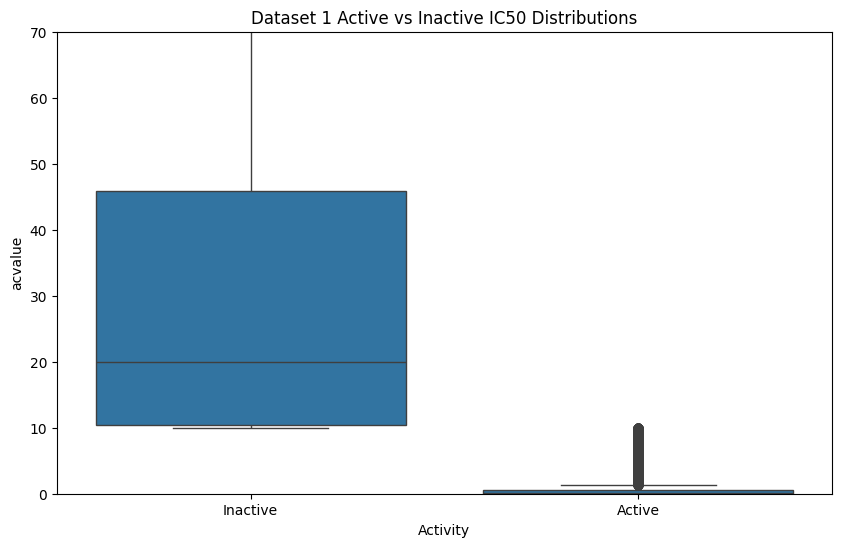

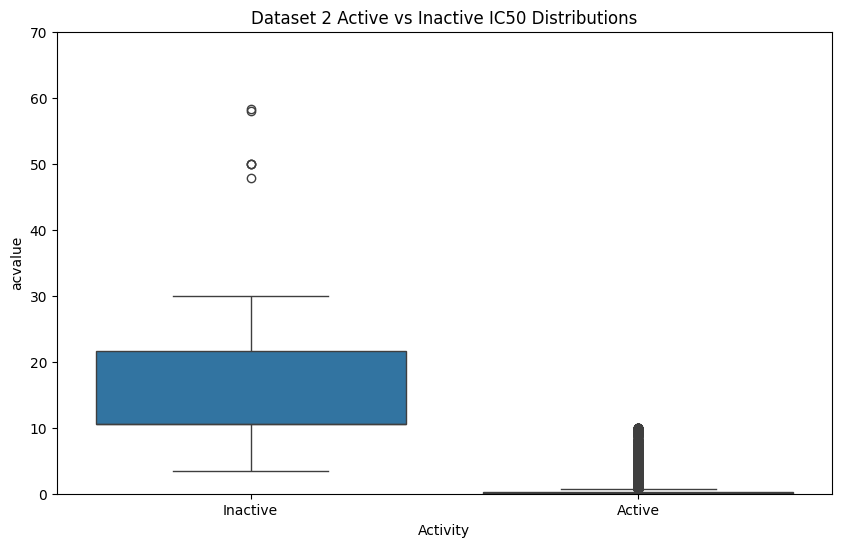

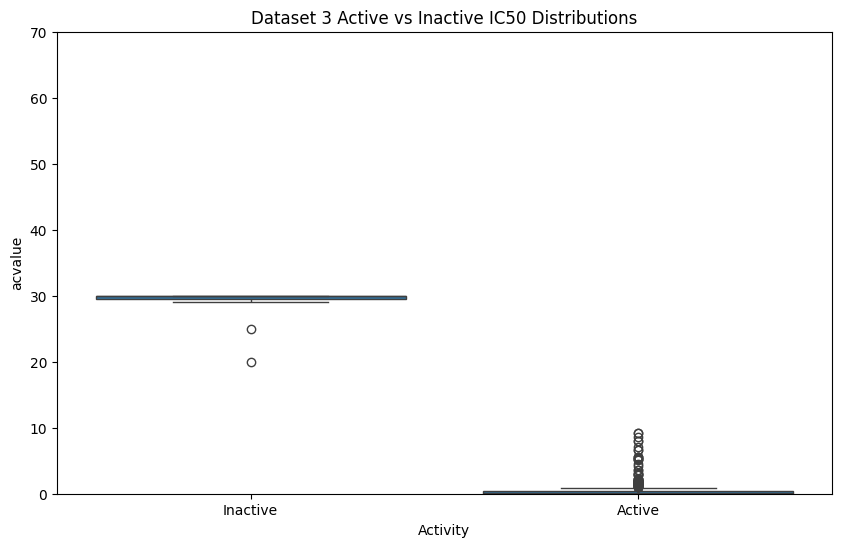

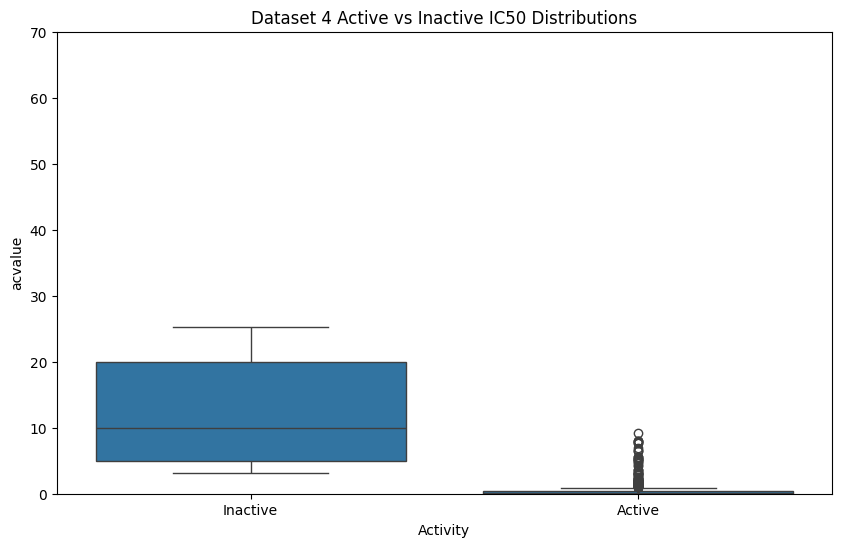

In [ ]:
for i, dataset in enumerate(pc_data):
  inactives = dataset[dataset['activity'] == 'Inactive']
  actives = dataset[dataset['activity'] == 'Active']

  # Create side-by-side boxplots
  plt.figure(figsize=(10, 6))
  sns.boxplot(x='activity', y='acvalue', data=pd.concat([inactives, actives]))
  plt.title(f'Dataset {i+1} Active vs Inactive IC50 Distributions')
  plt.ylim(0, 70)
  plt.xlabel('Activity')
  plt.ylabel('acvalue')
  plt.show()

# Data Cleaning

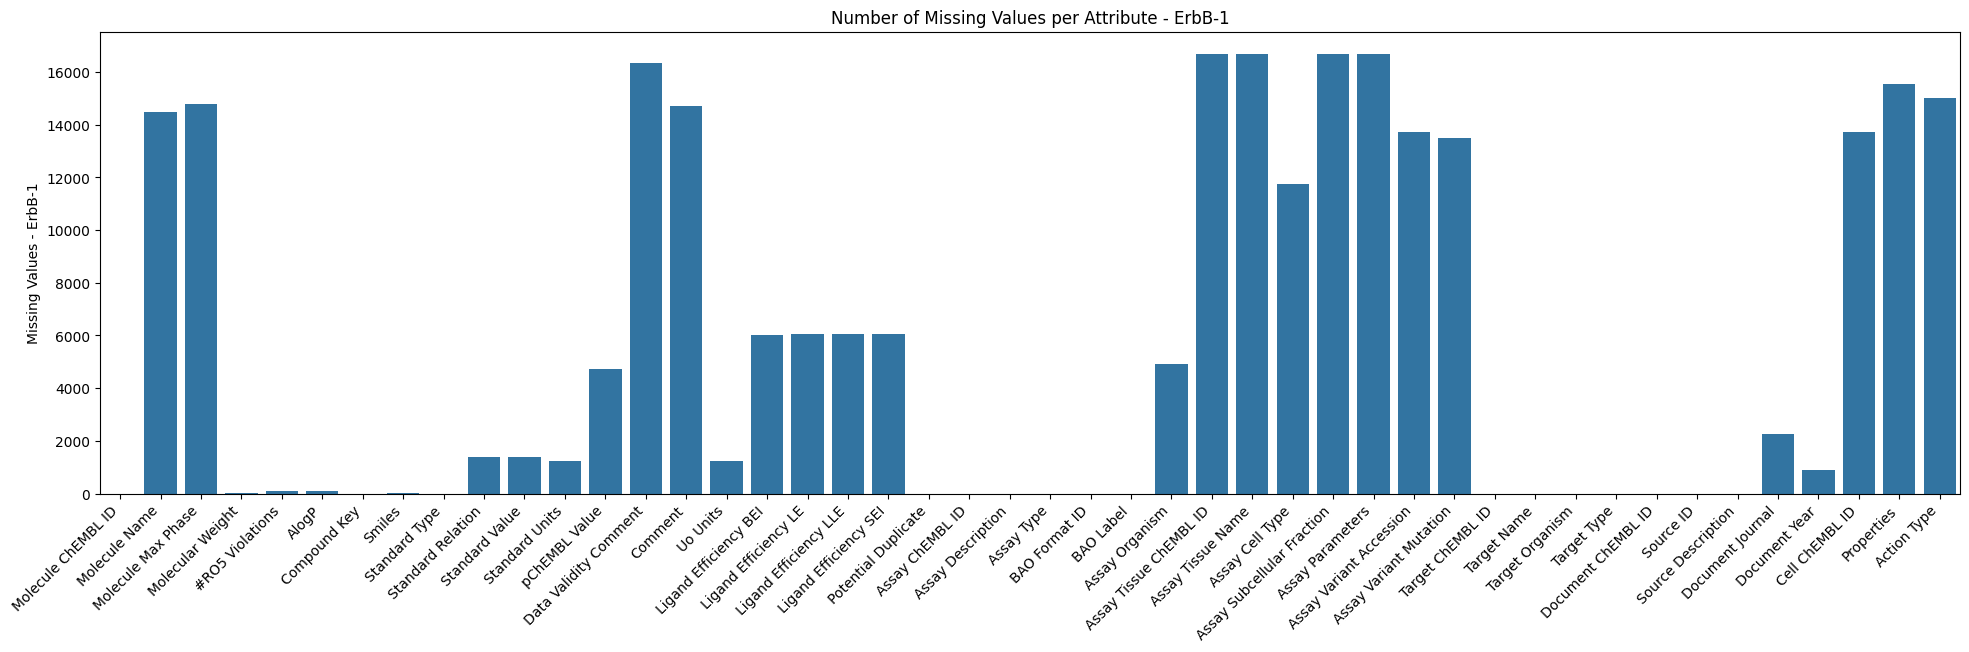

In [ ]:
missing_1 = erbb1_data.isna().sum(axis=0)
missing_1_df = pd.DataFrame({'Attribute': missing_1.index,
                             'Count': missing_1.values})

plt.figure(plt.figure(figsize=(24, 6)))
sns.barplot(missing_1)
plt.xticks(rotation=45, ha='right')
plt.title('Number of Missing Values per Attribute - ErbB-1')
plt.ylabel('Missing Values - ErbB-1')
plt.show()

In [ ]:
def is_positive(row):
    conditions = (
        (((row['Standard Relation'] == "'='") | (row['Standard Relation'] == "'<='"))
         & (row['Standard Value'] <= 9999)) |
        ((row['Standard Relation'] == "'<'") & (row['Standard Value'] < 10000))
    )

    if conditions:
        return 1
    else:
        return 0

def clean_data(chemblData):

    conditions = (
        (chemblData['Assay Type'].isin(['F', 'A', 'T'])) | #only interested in binding assays
        (chemblData['Standard Units'] == 'ug.mL-1') | #unit that requires more complicated conversion
        (chemblData['Smiles'].isna()) | #no Smiles string
        ((chemblData['Standard Value'].isna()) & # Missing value + Activity not determined
        (chemblData['Comment'].isin([np.nan, 'Not Determined', 'ND']))) |
        (chemblData['Data Validity Comment'].isin(['Outside typical range',
                                                  'Potential transcription error'])) # Potentially invalid data (and outliers)
    )

    chemblDataClean = chemblData[~conditions].copy() #filter out rows

    chemblDataClean.loc[chemblDataClean['Standard Units']
                        .isin(['µM', '/uM']), 'Standard Value'] *= 1000
    chemblDataClean['Standard Units'] = 'nM' # convert uM to nM

    standardRelationConditions = (
        (chemblDataClean['Standard Relation'] == "'='") |
        ((chemblDataClean['Standard Relation'].isna()) & (chemblDataClean['Standard Value'].isna())) |
        ((chemblDataClean['Standard Relation'] == "'<'") & (chemblDataClean['Standard Value'] < 10001)) |
        ((chemblDataClean['Standard Relation'] == "'<='") & (chemblDataClean['Standard Value'] <= 9999)) |
        ((chemblDataClean['Standard Relation'] == "'>'") & (chemblDataClean['Standard Value'] > 9999)) |
        ((chemblDataClean['Standard Relation'] == "'>='") & (chemblDataClean['Standard Value'] >= 10000))
    )

    chemblDataClean = chemblDataClean[standardRelationConditions].copy() #filter out by standard relation

    chemblDataClean['Standard Value'] = pd.to_numeric(chemblDataClean['Standard Value'], errors='coerce')
    chemblDataClean['Standard Value'].fillna(11000, inplace=True)

    min_value = chemblDataClean.groupby('Molecule ChEMBL ID')['Standard Value'].idxmin() #for duplicates, keep the record with the lowest ic50 value
    chemblDataClean = chemblDataClean.loc[min_value]

    chemblDataClean['is_positive'] = chemblDataClean.apply(is_positive, axis=1)

    dataProcessed = chemblDataClean[['Molecule ChEMBL ID', 'Target ChEMBL ID', 'Smiles', 'Standard Value', 'is_positive']].reset_index(drop=True).copy()

    return dataProcessed


In [ ]:
erbb1_processed = clean_data(erbb1_data)
erbb2_processed = clean_data(erbb2_data)
erbb3_processed = clean_data(erbb3_data)
erbb4_processed = clean_data(erbb4_data)
erbb1_processed.head()

Molecule ChEMBL ID Target ChEMBL ID  \
0           CHEMBL10        CHEMBL203   
1         CHEMBL1006        CHEMBL203   
2         CHEMBL1009        CHEMBL203   
3          CHEMBL101        CHEMBL203   
4       CHEMBL101168        CHEMBL203   

                                              Smiles  Standard Value  \
0  C[S+]([O-])c1ccc(-c2nc(-c3ccc(F)cc3)c(-c3ccncc...         11000.0   
1                                  NCCCNCCSP(=O)(O)O         11000.0   
2                     N[C@@H](Cc1ccc(O)c(O)c1)C(=O)O          2880.0   
3              CCCCC1C(=O)N(c2ccccc2)N(c2ccccc2)C1=O         11000.0   
4                                     Nn1nnc2ccccc21         11000.0   

   is_positive  
0            0  
1            0  
2            1  
3            0  
4            0

In [ ]:
frames = [erbb1_processed, erbb2_processed, erbb3_processed, erbb4_processed]
combined_data = pd.concat(frames).reset_index(drop=True)

combined_data.head()

Molecule ChEMBL ID Target ChEMBL ID  \
0           CHEMBL10        CHEMBL203   
1         CHEMBL1006        CHEMBL203   
2         CHEMBL1009        CHEMBL203   
3          CHEMBL101        CHEMBL203   
4       CHEMBL101168        CHEMBL203   

                                              Smiles  Standard Value  \
0  C[S+]([O-])c1ccc(-c2nc(-c3ccc(F)cc3)c(-c3ccncc...         11000.0   
1                                  NCCCNCCSP(=O)(O)O         11000.0   
2                     N[C@@H](Cc1ccc(O)c(O)c1)C(=O)O          2880.0   
3              CCCCC1C(=O)N(c2ccccc2)N(c2ccccc2)C1=O         11000.0   
4                                     Nn1nnc2ccccc21         11000.0   

   is_positive  
0            0  
1            0  
2            1  
3            0  
4            0

In [ ]:
combined_data['is_positive'].value_counts()

is_positive
1    9156
0    3763
Name: count, dtype: int64

In [ ]:
combined_data.to_csv('/content/combinedData.csv')

# Data Preprocessing

In [ ]:
dataProcessed = pd.read_csv("combinedData.csv", sep=',', index_col=[0])
dataProcessed['Target ChEMBL ID'].value_counts().to_frame()

count
Target ChEMBL ID       
CHEMBL203          9371
CHEMBL1824         3244
CHEMBL3009          252
CHEMBL5838           52

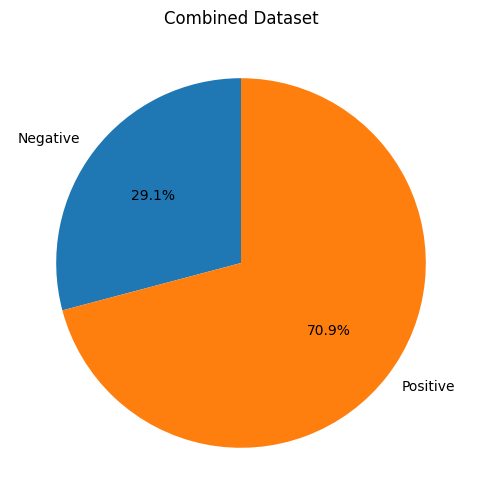

In [ ]:
positive_count = dataProcessed['is_positive'].sum()
negative_count = len(dataProcessed) - positive_count

labels = ['Negative', 'Positive']
sizes = [negative_count, positive_count]

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Combined Dataset')
plt.show()

In [ ]:
dataProcessed.groupby('Target ChEMBL ID')['is_positive'].value_counts().to_frame()

count
Target ChEMBL ID is_positive       
CHEMBL1824       1             1966
                 0             1278
CHEMBL203        1             6948
                 0             2423
CHEMBL3009       1              201
                 0               51
CHEMBL5838       1               41
                 0               11

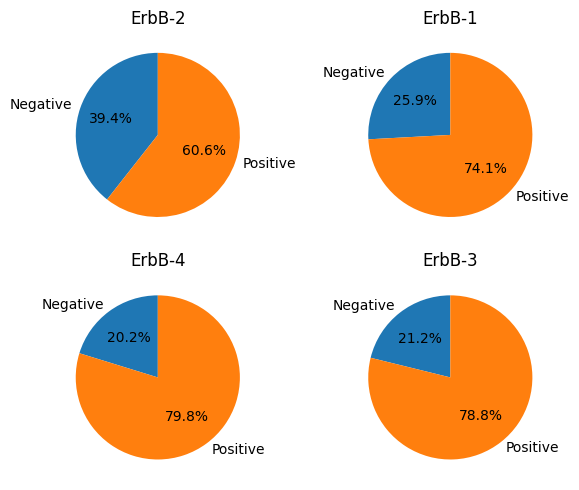

In [ ]:
grouped_data = dataProcessed.groupby('Target ChEMBL ID')['is_positive'].value_counts().unstack(fill_value=0)

target_names = {
    'CHEMBL1824': 'ErbB-2',
    'CHEMBL203': 'ErbB-1',
    'CHEMBL3009': 'ErbB-4',
    'CHEMBL5838': 'ErbB-3'
}

fig, axes = plt.subplots(2, 2, figsize=(6, 5))
axes = axes.flatten()
labels = ['Negative', 'Positive']

for i, (chembl_id, counts) in enumerate(grouped_data.iterrows()):
    ax = axes[i]
    ax.pie(counts, labels=labels, autopct='%1.1f%%', startangle=90)
    target_name = target_names.get(chembl_id)
    ax.set_title(target_name)

plt.tight_layout()
plt.show()

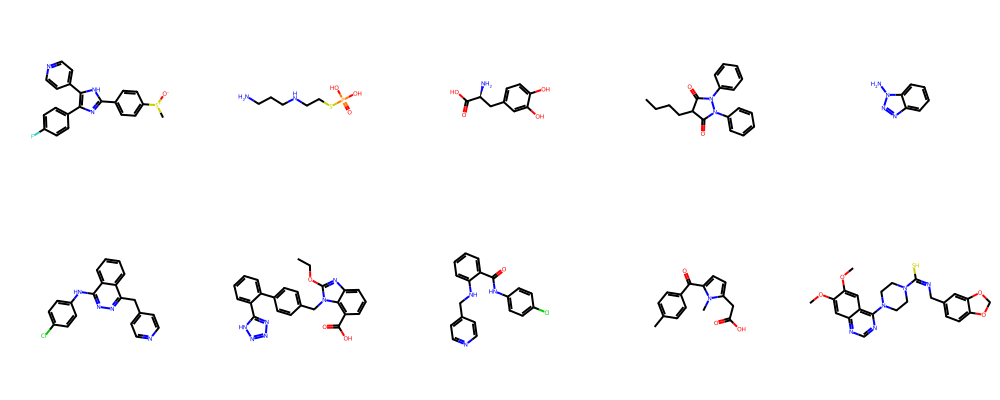

In [ ]:
dataProcessed['Molecule'] = dataProcessed['Smiles'].apply(Chem.MolFromSmiles)
Draw.MolsToGridImage(dataProcessed['Molecule'][:10],molsPerRow=5)

In [ ]:
dataProcessed['MolWt'] = dataProcessed['Molecule'].apply(Descriptors.MolWt) #Molecular Weight
dataProcessed['LogP'] = dataProcessed['Molecule'].apply(Descriptors.MolLogP) #Partition coeficcient
dataProcessed['TPSA'] = dataProcessed['Molecule'].apply(Descriptors.TPSA) #Topological Polar Surface Area
dataProcessed['NumRotatableBonds'] = dataProcessed['Molecule'].apply(Descriptors.NumRotatableBonds) #Number of Rotatable Bonds
dataProcessed['NumHDonors'] = dataProcessed['Molecule'].apply(Descriptors.NumHDonors) #Number of H-Bond Donors
dataProcessed['NumHAcceptors'] = dataProcessed['Molecule'].apply(Descriptors.NumHAcceptors) #Number of H-Bond Acceptors
dataProcessed['RingCount'] = dataProcessed['Molecule'].apply(Descriptors.RingCount) #Number of Rings
dataProcessed['HeavyAtomCount'] = dataProcessed['Molecule'].apply(Descriptors.HeavyAtomCount) #Number of Heavy Atoms
dataProcessed['NumHeteroatoms'] = dataProcessed['Molecule'].apply(Descriptors.NumHeteroatoms) #Number of Heteroatoms
dataProcessed['NumAromaticRings'] = dataProcessed['Molecule'].apply(Descriptors.NumAromaticRings) #Number of Aromatic Rings
dataProcessed['NumAliphaticRings'] = dataProcessed['Molecule'].apply(Descriptors.NumAliphaticRings) #Number of Aliphatic Rings
dataProcessed['NumSaturatedRings'] = dataProcessed['Molecule'].apply(Descriptors.NumSaturatedRings) #Number of Saturated Rings
dataProcessed['NumValenceElectrons'] = dataProcessed['Molecule'].apply(Descriptors.NumValenceElectrons) #Number of Valence Electrons


In [ ]:
fingerprints = {}

for smile in dataProcessed['Smiles']:
  mol = Chem.MolFromSmiles(smile)
  fingerprint = AllChem.GetMorganFingerprintAsBitVect(mol, radius = 2)
  fingerprints[smile] = fingerprint

dataProcessed['Fingerprint'] = dataProcessed['Smiles'].map(fingerprints)

In [ ]:
dataProcessed.columns

Index(['Molecule ChEMBL ID', 'Target ChEMBL ID', 'Smiles', 'Standard Value',
       'is_positive', 'Protein Sequence', 'Protein Encoding', 'Molecule',
       'MolWt', 'LogP', 'TPSA', 'NumRotatableBonds', 'NumHDonors',
       'NumHAcceptors', 'RingCount', 'HeavyAtomCount', 'NumHeteroatoms',
       'NumAromaticRings', 'NumAliphaticRings', 'NumSaturatedRings',
       'NumValenceElectrons', 'Fingerprint'],
      dtype='object')

In [ ]:
dataFeaturesOnly = dataProcessed.drop(['Molecule ChEMBL ID', 'Smiles','is_positive',
                          'Molecule', 'Fingerprint', 'Target ChEMBL ID',
                                     'Protein Sequence', 'Protein Encoding' ], axis = 1)
dataFeaturesOnly.corr()

Standard Value     MolWt      LogP      TPSA  \
Standard Value             1.000000 -0.212174 -0.139277 -0.072847   
MolWt                     -0.212174  1.000000  0.475055  0.652911   
LogP                      -0.139277  0.475055  1.000000 -0.190632   
TPSA                      -0.072847  0.652911 -0.190632  1.000000   
NumRotatableBonds         -0.223900  0.748719  0.369006  0.535084   
NumHDonors                -0.011557  0.395394 -0.266949  0.785169   
NumHAcceptors             -0.206191  0.788951  0.057974  0.828616   
RingCount                 -0.146460  0.747261  0.449151  0.392101   
HeavyAtomCount            -0.200361  0.977530  0.478489  0.656296   
NumHeteroatoms            -0.201286  0.871902  0.155935  0.828297   
NumAromaticRings          -0.154782  0.557236  0.663650  0.184451   
NumAliphaticRings         -0.023352  0.380490 -0.140825  0.320991   
NumSaturatedRings         -0.090138  0.413393 -0.128223  0.356611   
NumValenceElectrons       -0.199791  0.978211  0.429929  0.679081   

                     NumRotatableBonds  NumHDonors  NumHAcceptors  RingCount  \
Standard Value               -0.223900   -0.011557      -0.206191  -0.146460   
MolWt                         0.748719    0.395394       0.788951   0.747261   
LogP                          0.369006   -0.266949       0.057974   0.449151   
TPSA                          0.535084    0.785169       0.828616   0.392101   
NumRotatableBonds             1.000000    0.348813       0.633043   0.359816   
NumHDonors                    0.348813    1.000000       0.493108   0.189051   
NumHAcceptors                 0.633043    0.493108       1.000000   0.633442   
RingCount                     0.359816    0.189051       0.633442   1.000000   
HeavyAtomCount                0.752192    0.389449       0.799283   0.790255   
NumHeteroatoms                0.683916    0.524617       0.892061   0.584269   
NumAromaticRings              0.432585    0.027567       0.411454   0.686369   
NumAliphaticRings            -0.001450    0.223749       0.391004   0.575880   
NumSaturatedRings             0.124269    0.262308       0.459032   0.569048   
NumValenceElectrons           0.762687    0.415691       0.811816   0.761292   

                     HeavyAtomCount  NumHeteroatoms  NumAromaticRings  \
Standard Value            -0.200361       -0.201286         -0.154782   
MolWt                      0.977530        0.871902          0.557236   
LogP                       0.478489        0.155935          0.663650   
TPSA                       0.656296        0.828297          0.184451   
NumRotatableBonds          0.752192        0.683916          0.432585   
NumHDonors                 0.389449        0.524617          0.027567   
NumHAcceptors              0.799283        0.892061          0.411454   
RingCount                  0.790255        0.584269          0.686369   
HeavyAtomCount             1.000000        0.844368          0.599825   
NumHeteroatoms             0.844368        1.000000          0.418668   
NumAromaticRings           0.599825        0.418668          1.000000   
NumAliphaticRings          0.390546        0.316636         -0.199288   
NumSaturatedRings          0.422434        0.384523         -0.115754   
NumValenceElectrons        0.995313        0.857446          0.532234   

                     NumAliphaticRings  NumSaturatedRings  NumValenceElectrons  
Standard Value               -0.023352          -0.090138            -0.199791  
MolWt                         0.380490           0.413393             0.978211  
LogP                         -0.140825          -0.128223             0.429929  
TPSA                          0.320991           0.356611             0.679081  
NumRotatableBonds            -0.001450           0.124269             0.762687  
NumHDonors                    0.223749           0.262308             0.415691  
NumHAcceptors                 0.391004           0.459032             0.811816  
RingCount                     0.575880  

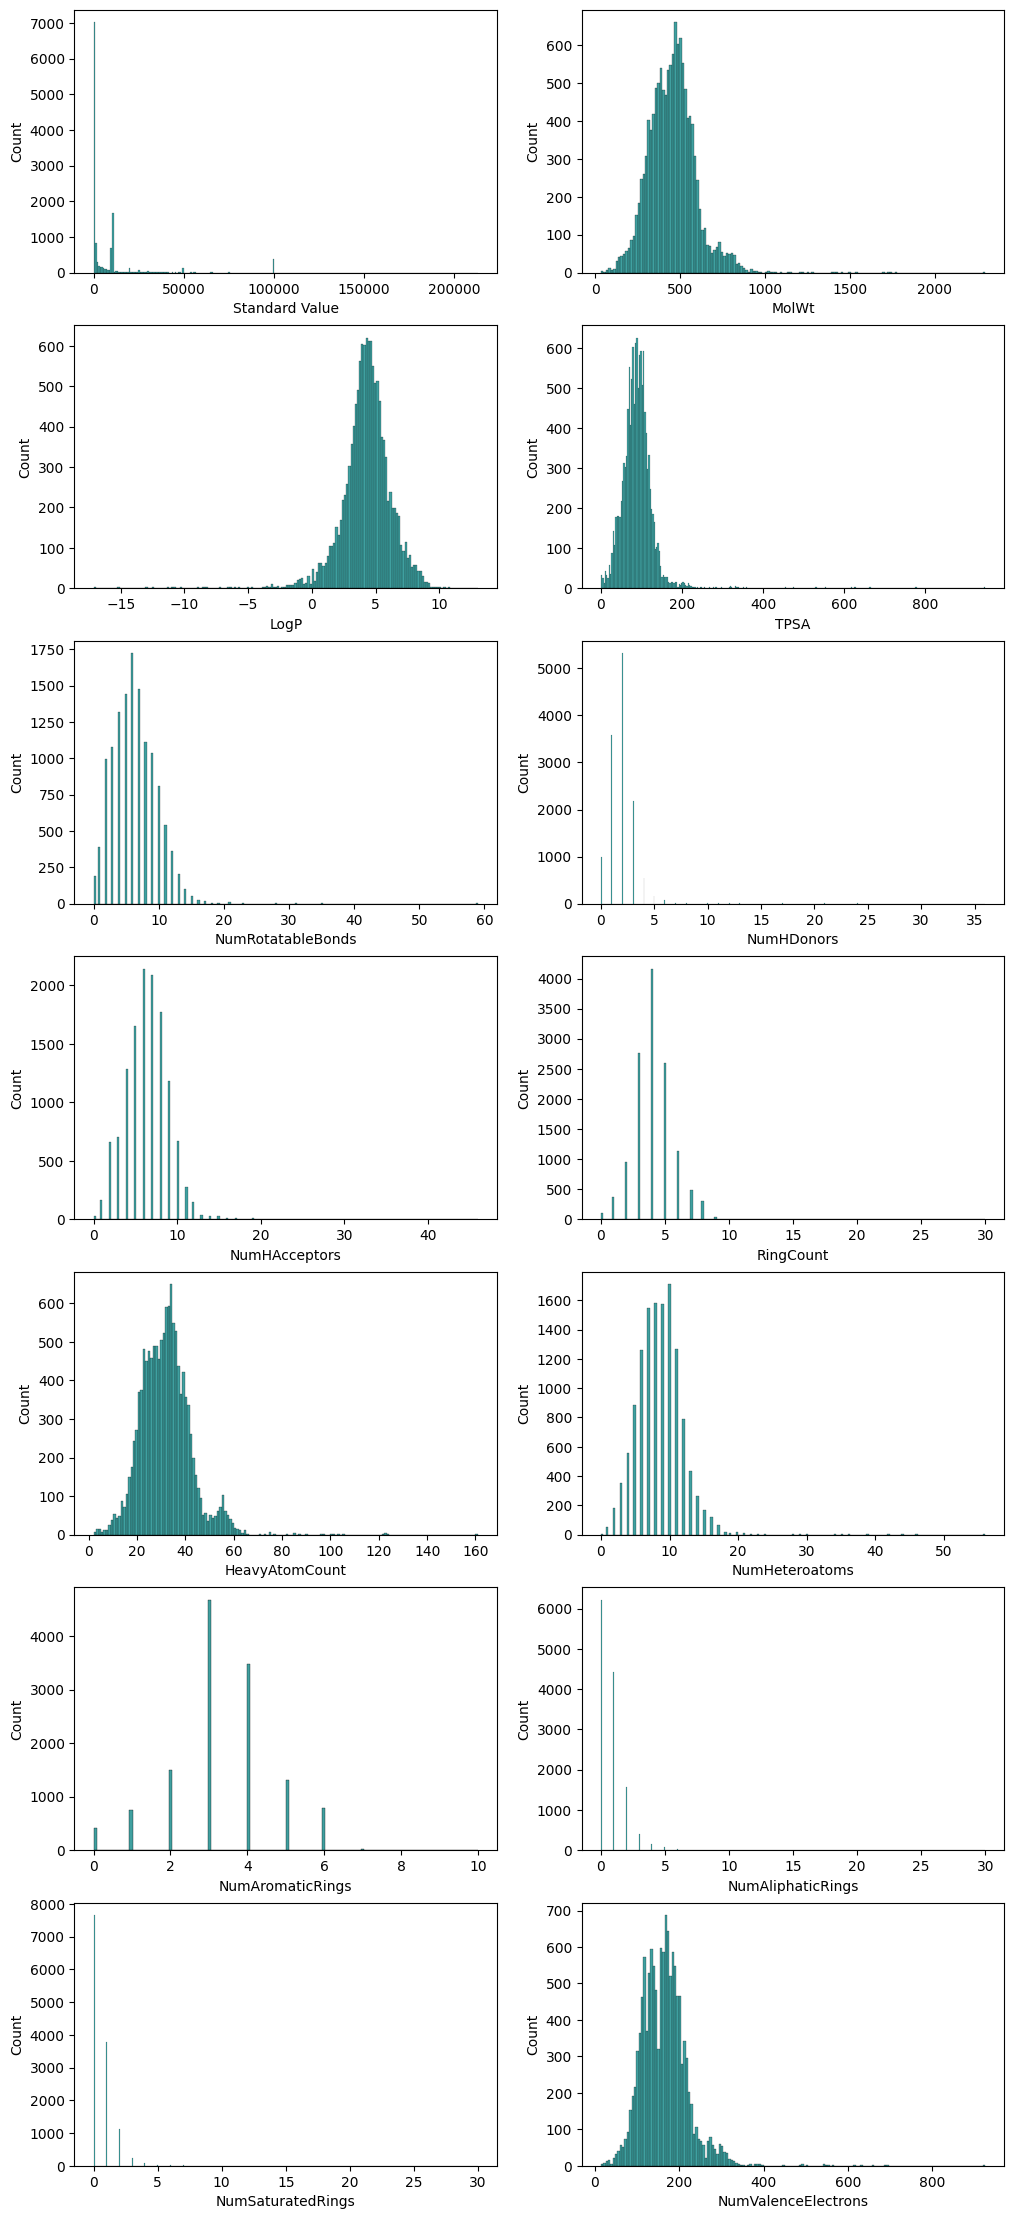

In [ ]:
fig, axs = plt.subplots(7, 2, figsize=(12, 28))


features = ["Standard Value", "MolWt", "LogP", "TPSA", "NumRotatableBonds", "NumHDonors", "NumHAcceptors",
                 "RingCount", "HeavyAtomCount", "NumHeteroatoms", "NumAromaticRings", "NumAliphaticRings",
                 "NumSaturatedRings", "NumValenceElectrons"]

i = j =  0

for feature in features:
  sns.histplot(data=dataProcessed, x=feature, color="teal", ax=axs[i, j])
  j = j+1
  if j == 2:
      i = i+1
      j= 0

plt.show()

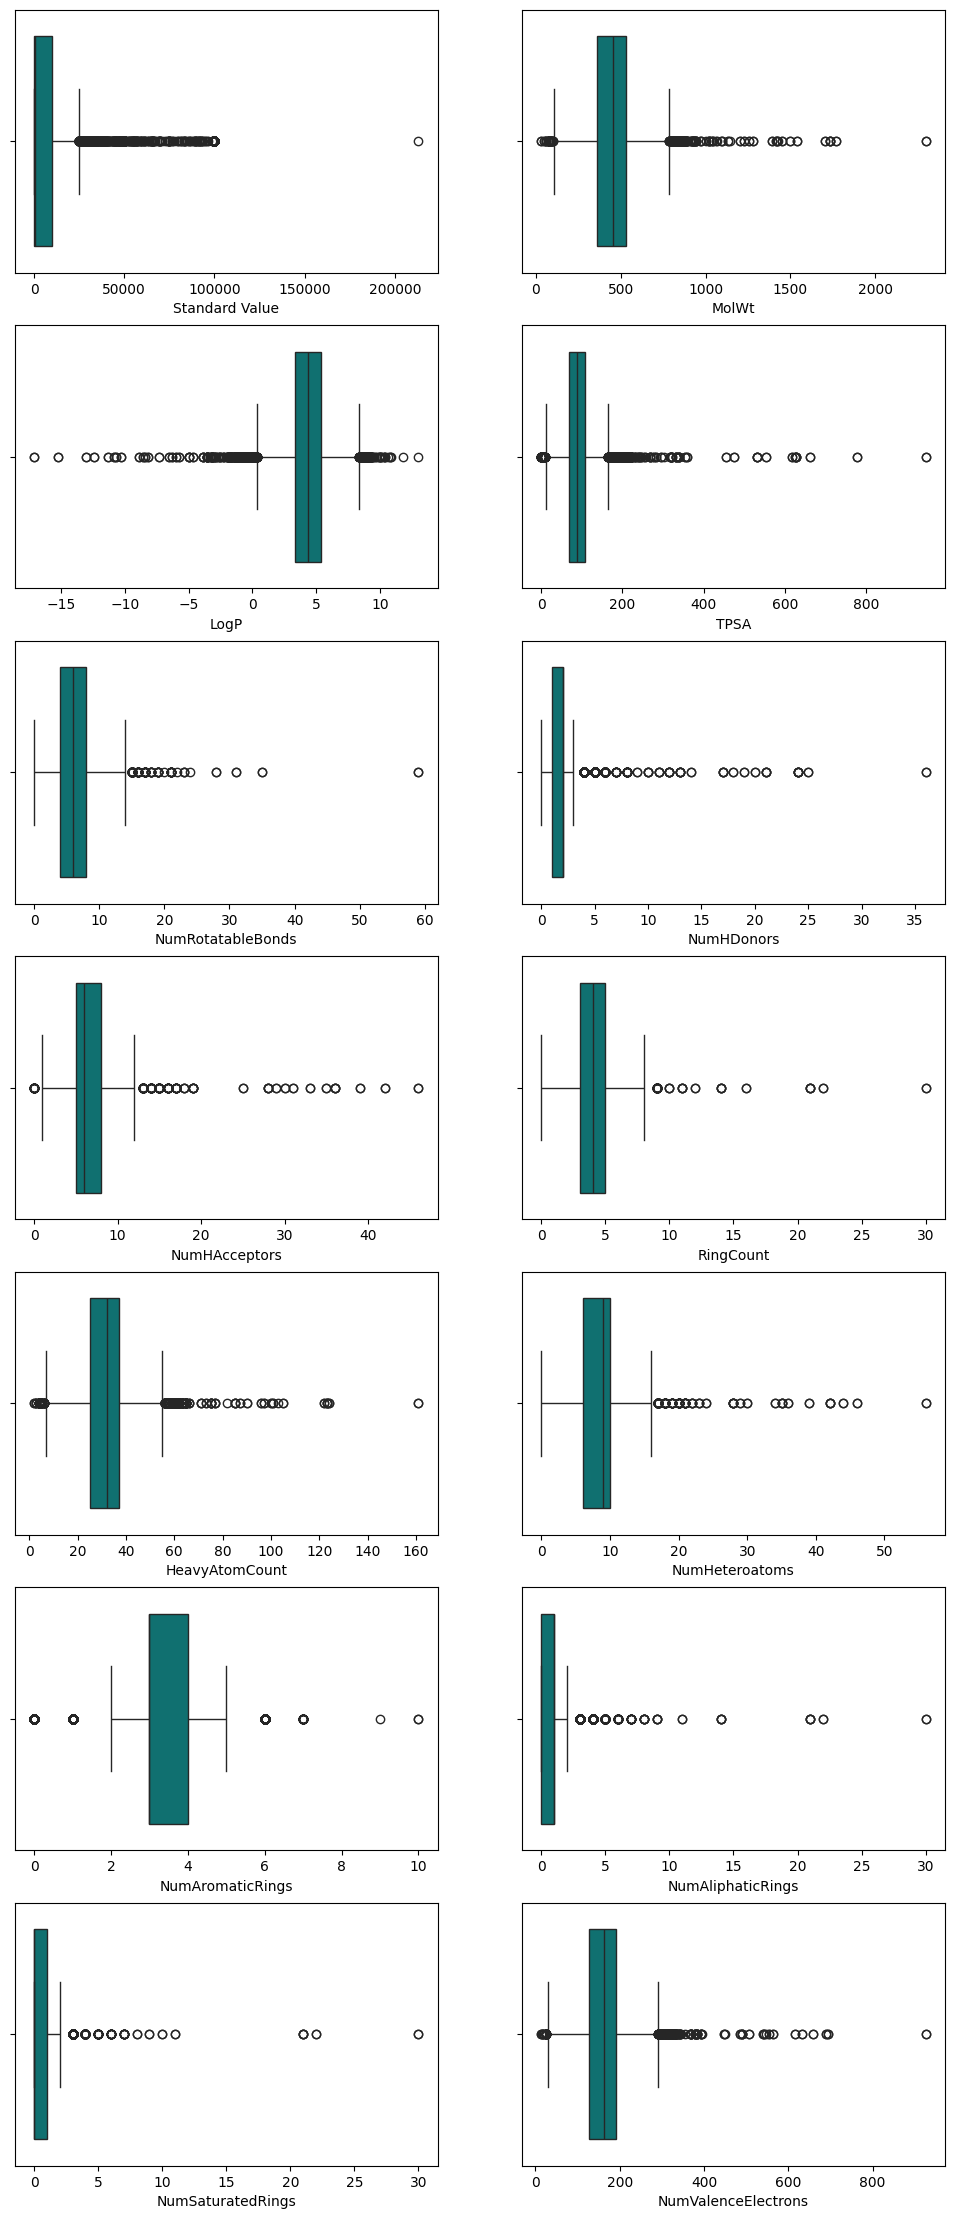

In [ ]:
fig, axs = plt.subplots(7, 2, figsize=(12, 28))
i = j =  0

for feature in features:
  sns.boxplot(data=dataProcessed, x=feature, color="teal", ax=axs[i, j])
  j = j+1
  if j == 2:
      i = i+1
      j= 0

plt.show()

In [ ]:
def remove_outliers(relevant_features_dataset, full_dataset):
  outliers = LocalOutlierFactor().fit_predict(relevant_features_dataset)
  mask = outliers != -1

  return dataProcessed.loc[mask, :]

dataOutliersRemoved = remove_outliers(dataFeaturesOnly, dataProcessed)
dataOutliersRemoved.shape

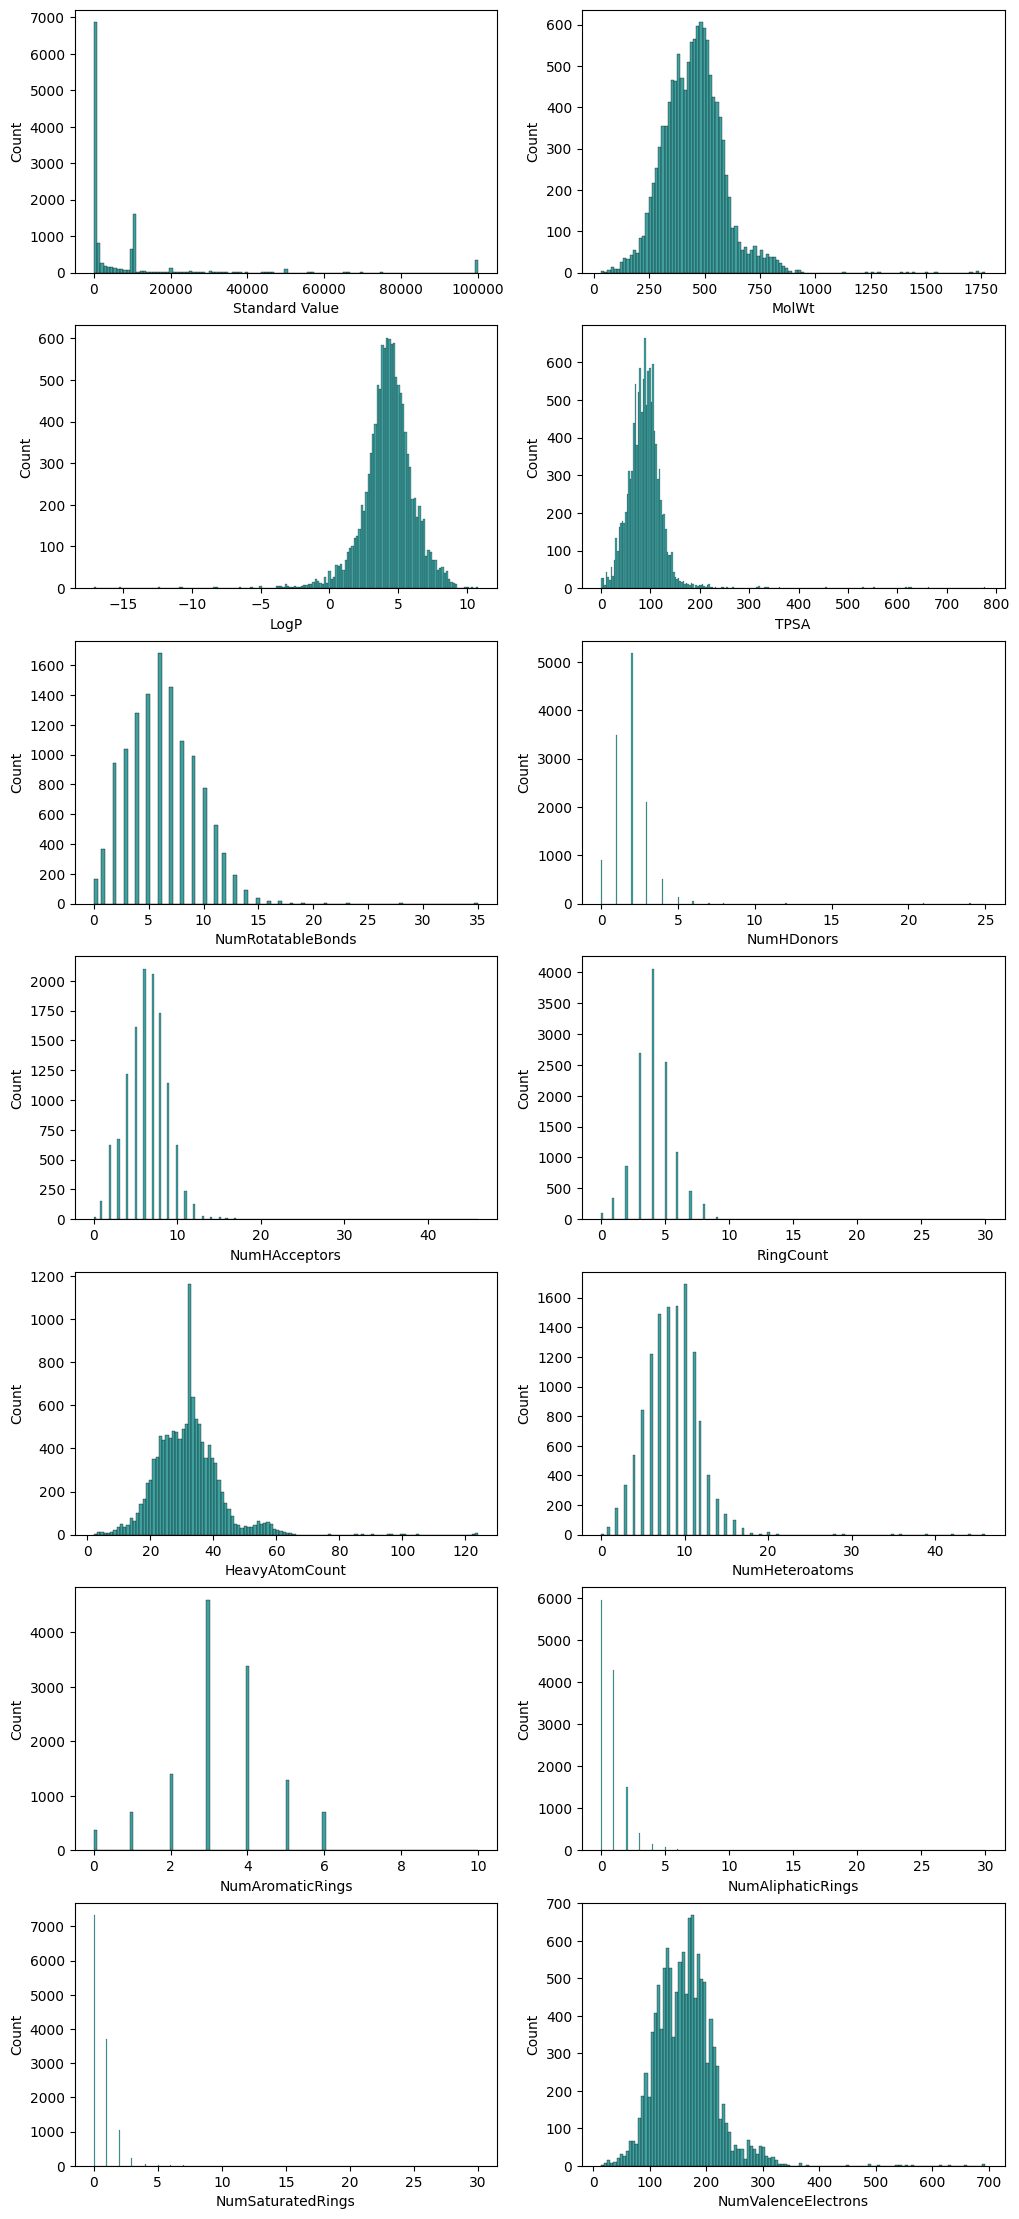

In [ ]:
fig, axs = plt.subplots(7, 2, figsize=(12, 28))

features = dataFeaturesOnly.columns

i = j =  0

for feature in features:
  sns.histplot(data=dataOutliersRemoved, x=feature, color="teal", ax=axs[i, j])
  j = j+1
  if j == 2:
      i = i+1
      j= 0

plt.show()

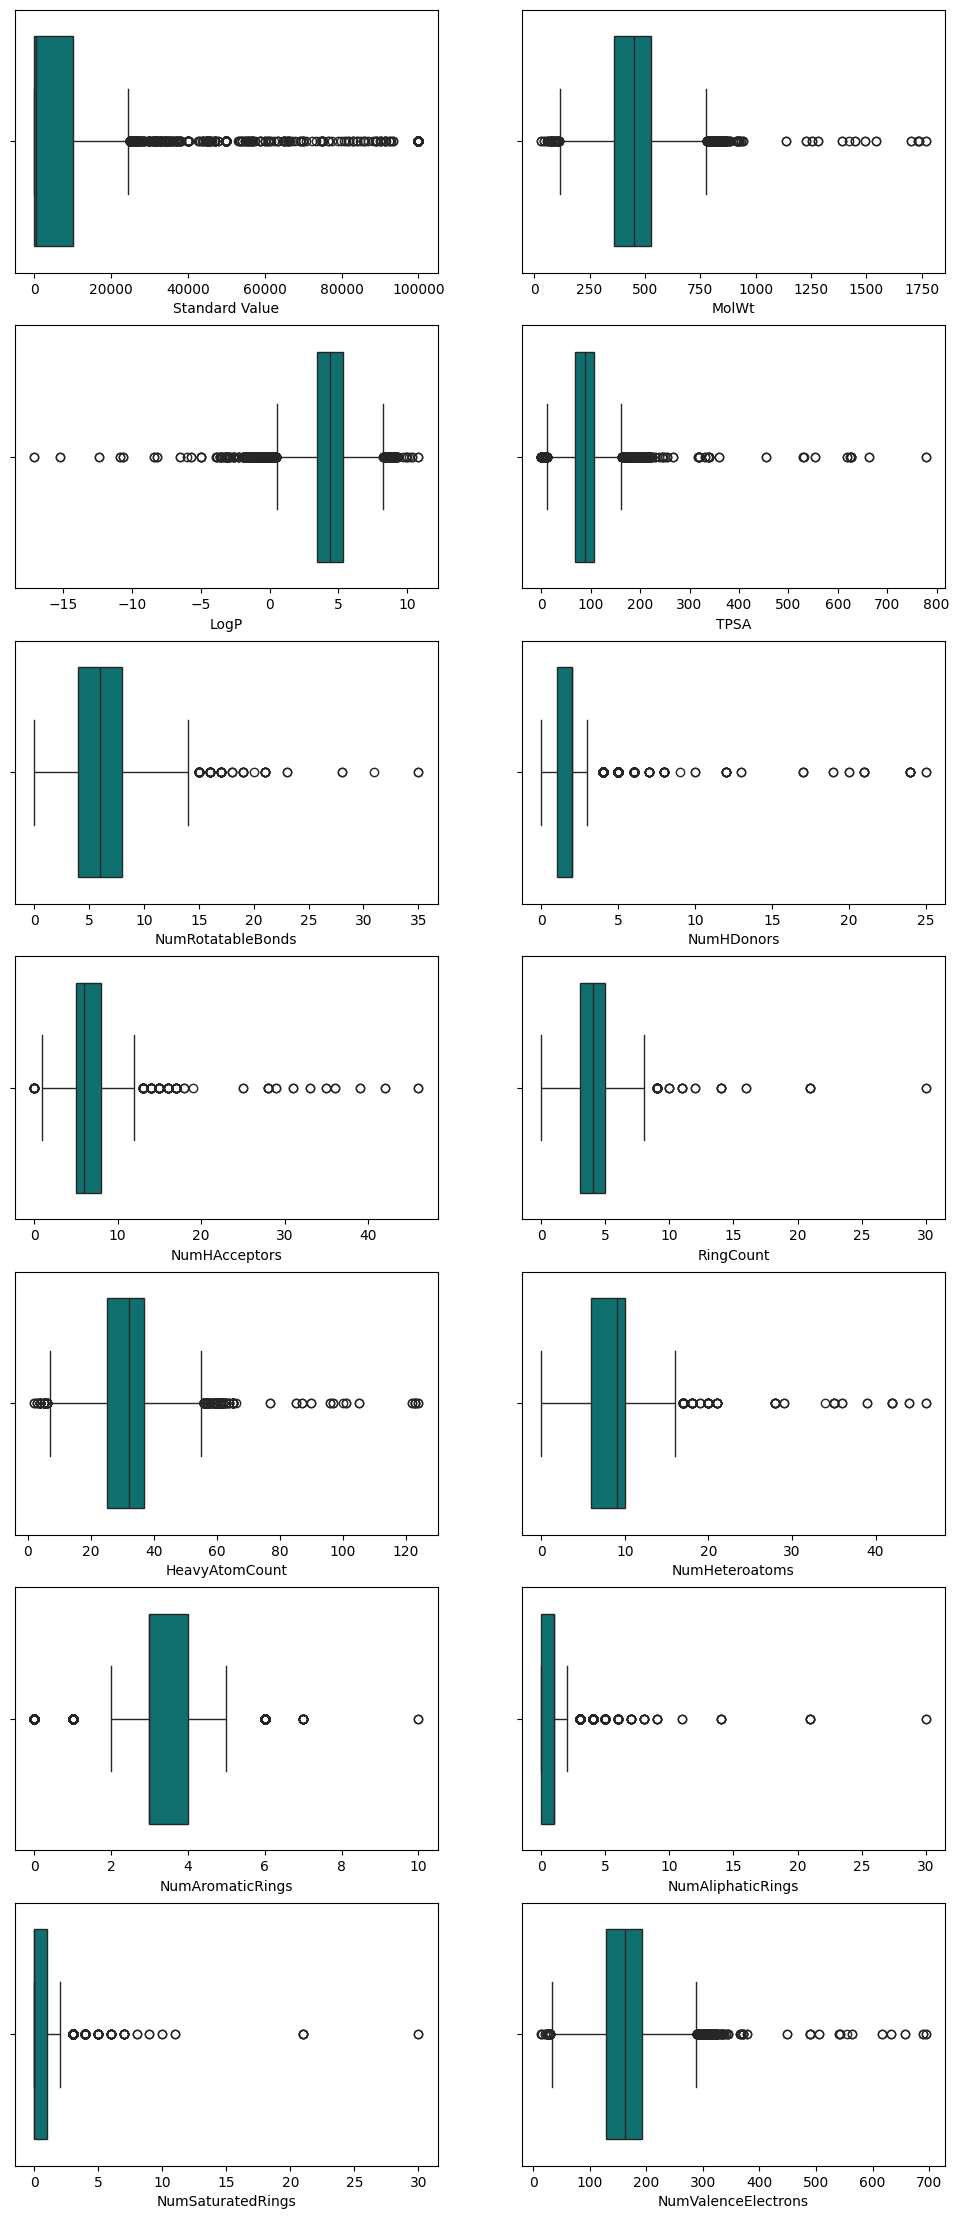

In [ ]:
fig, axs = plt.subplots(7, 2, figsize=(12, 28))

features = dataFeaturesOnly.columns

i = j =  0

for feature in features:
  sns.boxplot(data=dataOutliersRemoved, x=feature, color="teal", ax=axs[i, j])
  j = j+1
  if j == 2:
      i = i+1
      j= 0

plt.show()

In [ ]:
dataOutliersRemoved.to_csv('/content/dataOutliersRemoved.csv')

In [ ]:
def balance_data_undersample(x, y):

    undersample = RandomUnderSampler(random_state=SEED)
    x_us, y_us = undersample.fit_resample(x,y)

    return x_us, y_us

def balance_data_smote(x, y):

  oversample = SMOTE(random_state=SEED)
  x_os, y_os = oversample.fit_resample(x, y)

  return x_os, y_os

In [ ]:
def prepare_data(data, include_validation):


    x_encoded = pd.get_dummies(data, columns=['Target ChEMBL ID'])

    x_features = x_encoded.drop(['Molecule ChEMBL ID', 'Smiles', 'Standard Value',
                            'is_positive', 'Molecule', 'Fingerprint',
                                    'Protein Sequence', 'Protein Encoding' ], axis = 1)

    x_fingerprint = np.array(data['Fingerprint'].tolist())

    x_combined = np.concatenate((x_features, x_fingerprint), axis=1)

    y = data['is_positive']

    if(include_validation == True):
      x_train, x_test, y_train, y_test = model_selection.train_test_split(
        x_combined, y, test_size=0.2, shuffle=True, random_state=SEED)

      x_train_balanced, y_train_balanced = balance_data_smote(x_train, y_train)

      x_train, x_validate, y_train, y_validate = model_selection.train_test_split(
          x_train_balanced, y_train_balanced, test_size=0.25, shuffle=True, random_state=SEED)

      return x_train, x_test, x_validate, y_validate, y_train, y_test

    x_train, x_test, y_train, y_test = model_selection.train_test_split(
        x_combined, y, test_size=0.3, shuffle=True, random_state=SEED)

    x_train_balanced, y_train_balanced = balance_data_smote(x_train, y_train)

    return x_train_balanced, x_test, y_train_balanced, y_test

def cross_validate(p, x, y, classifier_name, mean_results_df, results):

    #perform cross-validation and collect scores
    scoring = {'precision': 'precision',
               'recall': 'recall',
               'f1': 'f1',
               'specificity': make_scorer(specificity_score, greater_is_better=True),
               'roc_auc': 'roc_auc',
               'accuracy': 'accuracy'}
    names = "precision recall f1 roc_auc accuracy".split()
    cv = model_selection.StratifiedKFold(5, shuffle = True, random_state= SEED)

    scores = model_selection.cross_validate(p, x, y, scoring=scoring, cv=cv)
    scores = pd.DataFrame(scores)
    display(scores)


    plt.figure()
    grid = sns.catplot(x="variable", y="value", kind="box", data=scores.iloc[:, 2:].melt())
    grid.set_xticklabels(rotation=45)
    plt.title(f'{classifier_name} Cross Validation Metrics')
    plt.show()

    mean_scores = scores.mean()
    print("Mean Scores:")
    print(mean_scores)

    mean_results_df.loc[len(mean_results_df), :] = {'Classifier' : classifier_name,
                                    'Precision' : mean_scores.test_precision,
                                    'Recall' : mean_scores.test_recall,
                                    'F1 Score' : mean_scores.test_f1,
                                    'Specificity' : mean_scores.test_specificity,
                                    'ROC AUC' : mean_scores.test_roc_auc,
                                    'Accuracy': mean_scores.test_accuracy}

    scores['Classifier'] = classifier_name
    results.append(scores)

    #plot confusion matrix & ROC curve
    predicted = model_selection.cross_val_predict(p, x, y, cv=cv)
    matrix = confusion_matrix(y, predicted)

    plt.figure()
    fig = sns.heatmap(matrix, annot=True, fmt='d', cmap="Blues", cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'{classifier_name} Cross Validation Confusion Matrix')
    plt.show()

    if classifier_name != 'SVC':
      predicted_proba = model_selection.cross_val_predict(p, x, y, cv=cv, method='predict_proba')
      plt.figure()
      RocCurveDisplay.from_predictions(y, predicted_proba[:,1])
      plt.title(f'{classifier_name} Cross Validation ROC Curve')
      plt.show()

    return mean_results_df


def get_accuracy_per_target(x_test, y_test, predicted, classifier_name):

    x_targets = x_test[:, slice(13, 17)]
    y_test_reshaped = np.array(y_test).reshape(-1, 1)
    y_pred_reshaped = predicted.reshape(-1, 1)

    combined_data = np.concatenate((x_targets, y_test_reshaped, y_pred_reshaped), axis=1)

    combined_data_df = pd.DataFrame(combined_data, columns=['erbB-2', 'erbB-1',
                                                            'erbB-4', 'erbB-3',
                                                            'actual', 'predicted'])
    combined_data_df['actual'] = combined_data_df['actual'].astype(bool)
    combined_data_df['predicted'] = combined_data_df['predicted'].astype(bool)

    target1 = combined_data_df[combined_data_df['erbB-2'] == True]
    target2 = combined_data_df[combined_data_df['erbB-1'] == True]
    target3 = combined_data_df[combined_data_df['erbB-4'] == True]
    target4 = combined_data_df[combined_data_df['erbB-3'] == True]

    targets = [target1, target2, target3, target4]

    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    axes = axes.flatten()

    for i , target in enumerate(targets):
        ax = axes[i]
        matrix = confusion_matrix(target['actual'], target['predicted'])
        sns.heatmap(ax = ax, data = matrix, annot=True, fmt='d', cmap="Blues",
                    cbar=False)
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Actual')
        ax.set_title(f'{combined_data_df.columns[i]} Confusion Matrix')

    fig.suptitle(f'{classifier_name} Confusion Matrices Per Each Target')
    plt.show()

def train_test_model(p, x_train, y_train, x_test, y_test, classifier_name, results_df):

    #fit & predict
    p.fit(x_train, y_train)
    predicted = p.predict(x_test)

    #plot confusion matrix
    matrix = confusion_matrix(y_test, predicted)

    plt.figure()
    fig = sns.heatmap(matrix, annot=True, fmt='d', cmap="Blues", cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'{classifier_name} Confusion Matrix')
    plt.show()

    if(classifier_name == 'SVC'):
      predicted_proba = p.decision_function(x_test)
    else:
      predicted_proba = p.predict_proba(x_test)[:,1] #??

    #calculate, save & print metrics
    precision = metrics.precision_score(y_test, predicted)
    recall = metrics.recall_score(y_test, predicted)
    f1 = metrics.f1_score(y_test, predicted)
    specificity = specificity_score(y_test, predicted)
    roc_auc = metrics.roc_auc_score(y_test, predicted_proba)
    accuracy = metrics.accuracy_score(y_test, predicted)

    results_df.loc[len(results_df), :] = {'Classifier' : classifier_name,
                                    'Precision' : precision,
                                    'Recall': recall,
                                    'F1 Score' : f1,
                                    'Specificity' : specificity,
                                    'ROC AUC' : roc_auc,
                                    'Accuracy': accuracy}

    display(results_df.iloc[-1])

    get_accuracy_per_target(x_test, y_test, predicted, classifier_name)

    #plot precision recall curve
    precision, recall, _ = precision_recall_curve(y_test, predicted_proba)
    PrecisionRecallDisplay(precision=precision, recall=recall).plot()
    plt.title(f'{classifier_name} Test Set Precision-Recall Curve')
    plt.show()


    #plot roc curve
    plt.figure()
    RocCurveDisplay.from_predictions(y_test, predicted_proba)
    plt.title(f'{classifier_name} Test Set ROC Curve')
    plt.show()

    pickle.dump(p, open("trained_model.sav", 'wb'))

    return results_df


def find_best_params(estimator, parameters, x, y, cv):

    grid = HalvingGridSearchCV(estimator, parameters, scoring="f1", cv=cv, verbose=2)
    grid.fit(x, y)

    print(grid.best_params_)

    columns = "mean_test_score std_test_score params".split()
    df = pd.DataFrame(grid.cv_results_)[columns].sort_values(columns[0])
    display(df)

    return grid.best_estimator_

In [ ]:
x_train, x_test, y_train, y_test = prepare_data(dataOutliersRemoved, include_validation=False)


cv = model_selection.StratifiedKFold(5, shuffle = True, random_state= SEED)
column_transformer = ColumnTransformer(
    transformers=[('scaler', preprocessing.MinMaxScaler(), slice(0, 13))],
    remainder='passthrough'
)

cross_val_mean_results = pd.DataFrame(columns=['Classifier', 'Precision',
                                               'Recall', 'F1 Score', 'Specificity',
                                               'ROC AUC', 'Accuracy'])
test_results = pd.DataFrame(columns=['Classifier', 'Precision','Recall',
                                     'F1 Score','Specificity', 'ROC AUC', 'Accuracy'])
cross_val_results = []

# SVC

In [ ]:
classifier_SVC = SVC(random_state = SEED)

parameters_SVC = {
    "C": [0.01, 0.1, 1, 10, 100],
    "kernel": ['linear', 'rbf'],
    "gamma": ['scale', 'auto', 1, 0.1, 0.01, 0.001]
}

best_estimatorSVM = find_best_params(classifier_SVC, parameters_SVC, x_train, y_train, cv)
#C=0.1, gamma=0.001, kernel=linear;

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 460
max_resources_: 12438
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 60
n_resources: 460
Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV] END .................C=0.01, gamma=scale, kernel=linear; total time=   0.2s
[CV] END .................C=0.01, gamma=scale, kernel=linear; total time=   0.1s
[CV] END .................C=0.01, gamma=scale, kernel=linear; total time=   0.2s
[CV] END .................C=0.01, gamma=scale, kernel=linear; total time=   0.2s
[CV] END .................C=0.01, gamma=scale, kernel=linear; total time=   0.2s
[CV] END ....................C=0.01, gamma=scale, kernel=rbf; total time=   0.2s
[CV] END ....................C=0.01, gamma=scale, kernel=rbf; total time=   0.2s
[CV] END ....................C=0.01, gamma=scale, kernel=rbf; total time=   0.2s
[CV] END ....................C=0.01, gamma=scale, kernel=rbf; total time=   0.2s
[CV] END

KeyboardInterrupt: 

In [ ]:
classifier_SVC = SVC(C=0.1, kernel='linear', random_state = SEED)
p_SVC = pipeline.make_pipeline(column_transformer, classifier_SVC)

fit_time  score_time  test_precision  test_recall   test_f1  \
0  77.687530   33.772284        0.918301     0.903537  0.910859   
1  65.424787   28.086098        0.936081     0.894695  0.914920   
2  54.683339   20.410069        0.932603     0.889871  0.910736   
3  50.587330   18.987695        0.920701     0.886656  0.903358   
4  51.698053   24.235324        0.927379     0.893805  0.910283   

   test_specificity  test_roc_auc  test_accuracy  
0          0.919614      0.966224       0.911576  
1          0.938907      0.967377       0.916801  
2          0.935691      0.970435       0.912781  
3          0.923572      0.962267       0.905107  
4          0.930064      0.965168       0.911942

<Figure size 640x480 with 0 Axes>

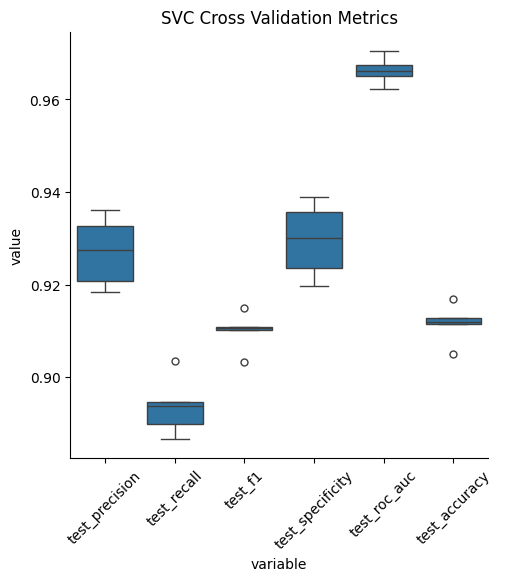

Mean Scores:
fit_time            60.016208
score_time          25.098294
test_precision       0.927013
test_recall          0.893713
test_f1              0.910031
test_specificity     0.929570
test_roc_auc         0.966294
test_accuracy        0.911641
dtype: float64


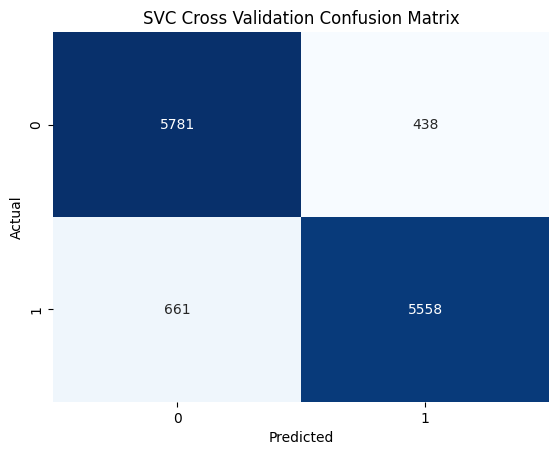

In [ ]:
cross_val_mean_results = cross_validate(p_SVC, x_train, y_train, 'SVC',
                                        cross_val_mean_results, cross_val_results)

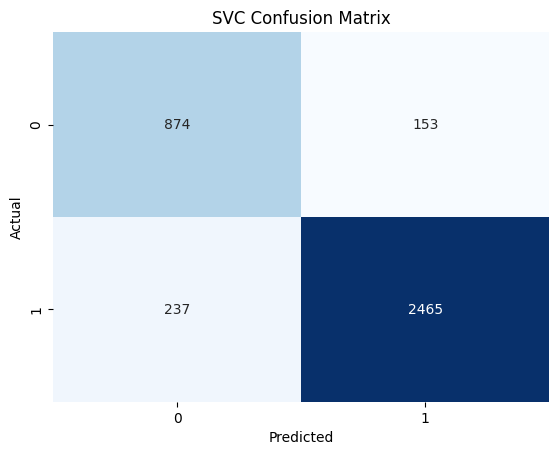

Classifier          SVC
Precision      0.941558
Recall         0.912287
F1 Score       0.926692
Specificity    0.851022
ROC AUC        0.945668
Accuracy       0.895414
Name: 0, dtype: object

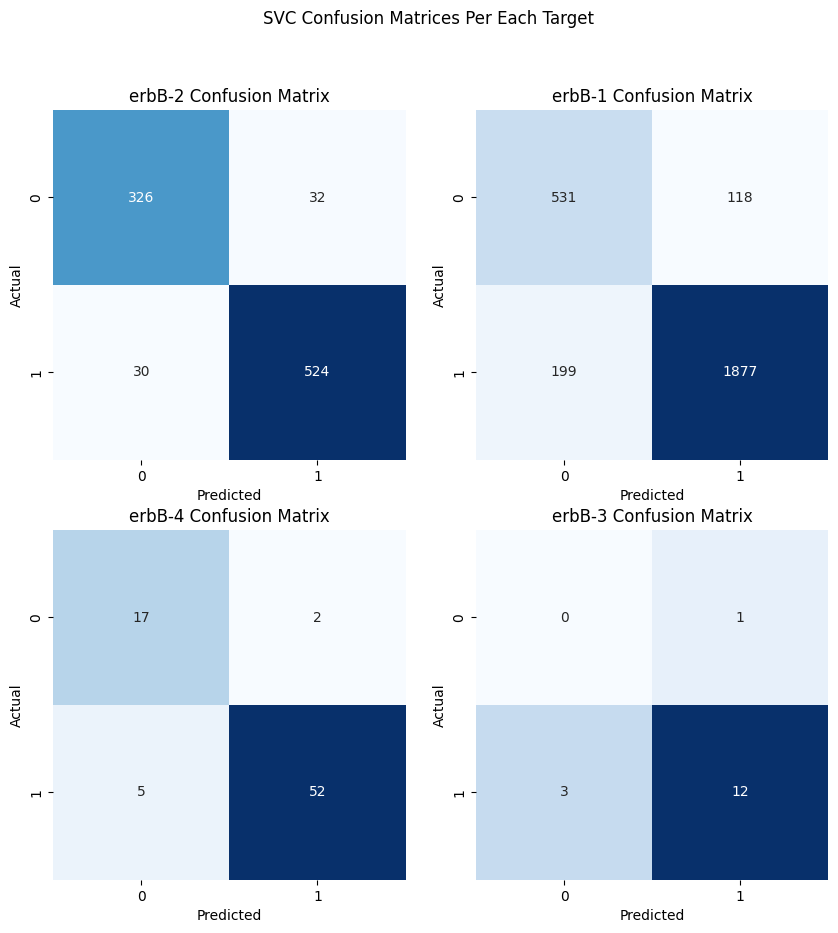

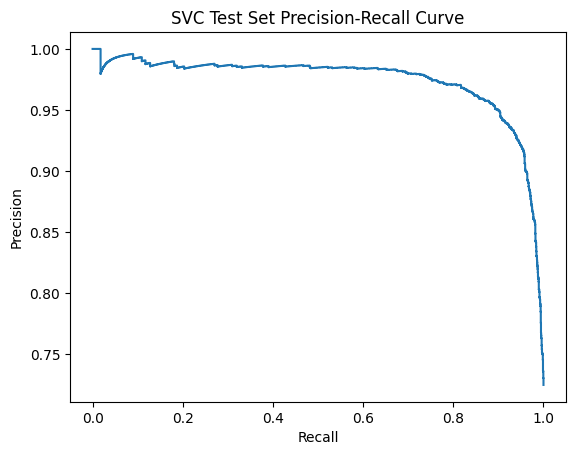

<Figure size 640x480 with 0 Axes>

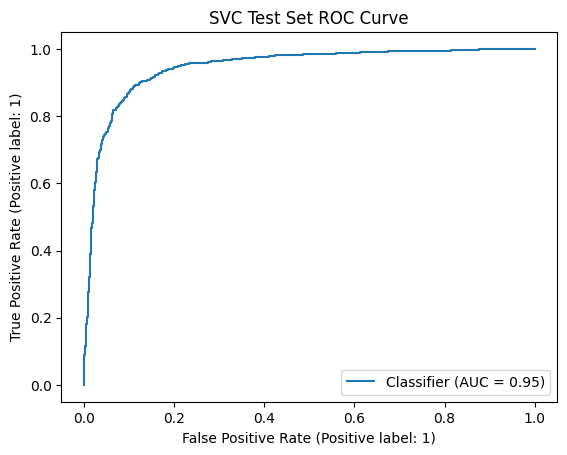

In [ ]:
test_results = train_test_model(p_SVC, x_train, y_train, x_test, y_test, 'SVC', test_results)

# Random Forest Classifier

In [ ]:
classifier_RF = RandomForestClassifier(random_state = SEED)

parameters_RF = {
    'n_estimators': [50, 100, 200, 300],
    'max_features': ['sqrt', 'log2', 'None'],
    'max_depth': [None, 40, 80, 120],
    'min_samples_leaf': [1, 3, 100], #change?
    'min_samples_split': [2, 8, 10, 12],
    'max_leaf_nodes':[None, 25, 100],
    'max_samples':[None, 0.2]
}

best_estimator_RF = find_best_params(classifier_RF, parameters_RF, x_train, y_train, cv)
# {'max_depth': 80, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

n_iterations: 6
n_required_iterations: 8
n_possible_iterations: 6
min_resources_: 20
max_resources_: 12438
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 3456
n_resources: 20
Fitting 5 folds for each of 3456 candidates, totalling 17280 fits
[CV] END max_depth=None, max_features=sqrt, max_leaf_nodes=None, max_samples=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, max_features=sqrt, max_leaf_nodes=None, max_samples=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END max_depth=None, max_features=sqrt, max_leaf_nodes=None, max_samples=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, max_features=sqrt, max_leaf_nodes=None, max_samples=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, max_features=sqrt, max_leaf_nodes=None, max_samples=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END max_depth=None, max_features=sqrt, max_leaf_nodes=None, max_samples=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, max_features=sqrt, max_leaf_nodes=None, max_samples=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, max_features=sqrt, max_leaf_nodes=None, max_samples=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, max_features=sqrt, max_leaf_nodes=None, max_samples=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, max_features=sqrt, max_leaf_nodes=None, max_samples=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END max_depth=None, max_features=sqrt, max_leaf_nodes=None, max_samples=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.3s
[CV] END max_depth=None, max_features=sqrt, max_leaf_nodes=None, max_samples=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.3s
[CV] END max_depth=None, max_features=sqrt, max_leaf_nodes=None, max_samples=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.3s
[CV] END max_depth=None, max_features=sqrt, max_leaf_nodes=None, max_samples=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.3s
[CV] END max_depth=None, max_features=sqrt, max_leaf_nodes=None, max_samples=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END max_depth=None, max_features=sqrt, max_leaf_nodes=None, max_samples=None, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.4s
[CV] END max_depth=None, max_features=sqrt, max_leaf_nodes=None, max_samples=None, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.4s
[CV] END max_depth=None, max_features=sqrt, max_leaf_nodes=None, max_samples=None, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.5s
[CV] END max_depth=None, max_features=sqrt, max_leaf_nodes=None, max_samples=None, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.4s
[CV] END max_depth=None, max_features=sqrt, max_leaf_nodes=None, max_samples=None, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.5s
[CV] END max_depth=None, max_features=sqrt, max_leaf_nodes=None, max_samples=None, min_samples_leaf=1, min_samples_split=8, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, max_featur

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END max_depth=None, max_features=sqrt, max_leaf_nodes=None, max_samples=None, min_samples_leaf=1, min_samples_split=8, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, max_features=sqrt, max_leaf_nodes=None, max_samples=None, min_samples_leaf=1, min_samples_split=8, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, max_features=sqrt, max_leaf_nodes=None, max_samples=None, min_samples_leaf=1, min_samples_split=8, n_estimators=50; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END max_depth=None, max_features=sqrt, max_leaf_nodes=None, max_samples=None, min_samples_leaf=1, min_samples_split=8, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, max_features=sqrt, max_leaf_nodes=None, max_samples=None, min_samples_leaf=1, min_samples_split=8, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, max_features=sqrt, max_leaf_nodes=None, max_samples=None, min_samples_leaf=1, min_samples_split=8, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, max_features=sqrt, max_leaf_nodes=None, max_samples=None, min_samples_leaf=1, min_samples_split=8, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, max_features=sqrt, max_leaf_nodes=None, max_samples=None, min_samples_leaf=1, min_samples_split=8, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END max_depth=None, max_features=sqrt, max_leaf_nodes=None, max_samples=None, min_samples_leaf=1, min_samples_split=8, n_estimators=200; total time=   0.3s
[CV] END max_depth=None, max_features=sqrt, max_leaf_nodes=None, max_samples=None, min_samples_leaf=1, min_samples_split=8, n_estimators=200; total time=   0.3s
[CV] END max_depth=None, max_features=sqrt, max_leaf_nodes=None, max_samples=None, min_samples_leaf=1, min_samples_split=8, n_estimators=200; total time=   0.3s
[CV] END max_depth=None, max_features=sqrt, max_leaf_nodes=None, max_samples=None, min_samples_leaf=1, min_samples_split=8, n_estimators=200; total time=   0.3s
[CV] END max_depth=None, max_features=sqrt, max_leaf_nodes=None, max_samples=None, min_samples_leaf=1, min_samples_split=8, n_estimators=200; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END max_depth=None, max_features=sqrt, max_leaf_nodes=None, max_samples=None, min_samples_leaf=1, min_samples_split=8, n_estimators=300; total time=   0.4s
[CV] END max_depth=None, max_features=sqrt, max_leaf_nodes=None, max_samples=None, min_samples_leaf=1, min_samples_split=8, n_estimators=300; total time=   0.6s
[CV] END max_depth=None, max_features=sqrt, max_leaf_nodes=None, max_samples=None, min_samples_leaf=1, min_samples_split=8, n_estimators=300; total time=   0.7s
[CV] END max_depth=None, max_features=sqrt, max_leaf_nodes=None, max_samples=None, min_samples_leaf=1, min_samples_split=8, n_estimators=300; total time=   0.7s
[CV] END max_depth=None, max_features=sqrt, max_leaf_nodes=None, max_samples=None, min_samples_leaf=1, min_samples_split=8, n_estimators=300; total time=   0.7s
[CV] END max_depth=None, max_features=sqrt, max_leaf_nodes=None, max_samples=None, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END max_depth=None, max_features=sqrt, max_leaf_nodes=None, max_samples=None, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, max_features=sqrt, max_leaf_nodes=None, max_samples=None, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, max_features=sqrt, max_leaf_nodes=None, max_samples=None, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, max_features=sqrt, max_leaf_nodes=None, max_samples=None, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, max_features=sqrt, max_leaf_nodes=None, max_samples=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END max_depth=None, max_features=sqrt, max_leaf_nodes=None, max_samples=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, max_features=sqrt, max_leaf_nodes=None, max_samples=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, max_features=sqrt, max_leaf_nodes=None, max_samples=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, max_features=sqrt, max_leaf_nodes=None, max_samples=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END max_depth=None, max_features=sqrt, max_leaf_nodes=None, max_samples=None, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.3s
[CV] END max_depth=None, max_features=sqrt, max_leaf_nodes=None, max_samples=None, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.3s
[CV] END max_depth=None, max_features=sqrt, max_leaf_nodes=None, max_samples=None, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.3s
[CV] END max_depth=None, max_features=sqrt, max_leaf_nodes=None, max_samples=None, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.3s
[CV] END max_depth=None, max_features=sqrt, max_leaf_nodes=None, max_samples=None, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END max_depth=None, max_features=sqrt, max_leaf_nodes=None, max_samples=None, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   0.4s
[CV] END max_depth=None, max_features=sqrt, max_leaf_nodes=None, max_samples=None, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   0.4s
[CV] END max_depth=None, max_features=sqrt, max_leaf_nodes=None, max_samples=None, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   0.4s
[CV] END max_depth=None, max_features=sqrt, max_leaf_nodes=None, max_samples=None, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   0.5s
[CV] END max_depth=None, max_features=sqrt, max_leaf_nodes=None, max_samples=None, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   0.4s
[CV] END max_depth=None, max_features=sqrt, max_leaf_nodes=None, max_samples=None, min_samples_leaf=1, min_samples_split=12, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, max_

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END max_depth=None, max_features=sqrt, max_leaf_nodes=None, max_samples=None, min_samples_leaf=1, min_samples_split=12, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, max_features=sqrt, max_leaf_nodes=None, max_samples=None, min_samples_leaf=1, min_samples_split=12, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, max_features=sqrt, max_leaf_nodes=None, max_samples=None, min_samples_leaf=1, min_samples_split=12, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, max_features=sqrt, max_leaf_nodes=None, max_samples=None, min_samples_leaf=1, min_samples_split=12, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


KeyboardInterrupt: 

In [ ]:
classifier_RF = RandomForestClassifier(max_depth = 80, max_features = 'log2',
                                          max_leaf_nodes = None, max_samples = None,
                                          min_samples_leaf = 1, min_samples_split = 2,
                                          n_estimators = 200, random_state = SEED)

p_RF = pipeline.make_pipeline(column_transformer, classifier_RF)

fit_time  score_time  test_precision  test_recall   test_f1  \
0  7.166517    0.574834        0.936471     0.959807  0.947995   
1  7.273546    0.566744        0.938193     0.951768  0.944932   
2  6.395282    0.533923        0.941223     0.952572  0.946864   
3  7.152939    0.574196        0.935127     0.950161  0.942584   
4  6.086030    0.510985        0.935612     0.946903  0.941224   

   test_specificity  test_roc_auc  test_accuracy  
0          0.934887      0.986546       0.947347  
1          0.937299      0.986597       0.944534  
2          0.940514      0.988238       0.946543  
3          0.934031      0.984200       0.942099  
4          0.934887      0.986549       0.940893

<Figure size 640x480 with 0 Axes>

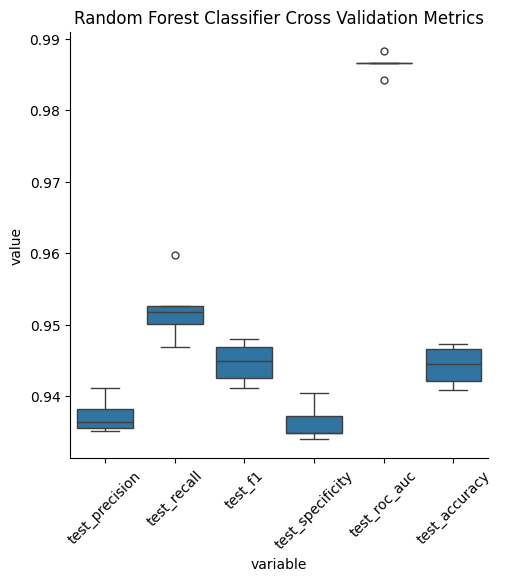

Mean Scores:
fit_time            6.814863
score_time          0.552137
test_precision      0.937325
test_recall         0.952242
test_f1             0.944720
test_specificity    0.936324
test_roc_auc        0.986426
test_accuracy       0.944283
dtype: float64


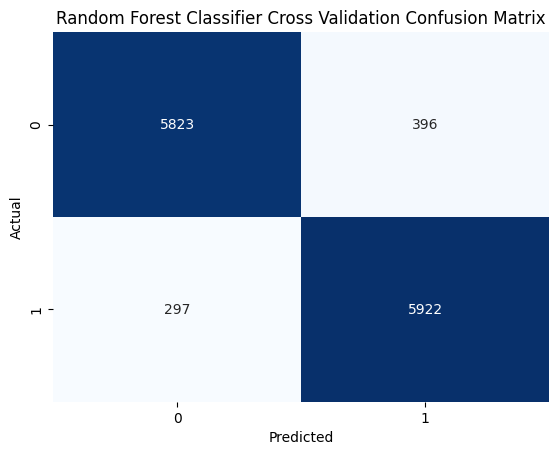

<Figure size 640x480 with 0 Axes>

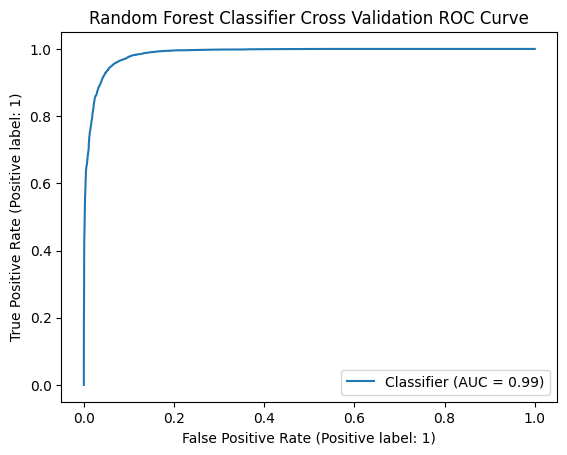

In [ ]:
cross_val_mean_results = cross_validate(p_RF, x_train, y_train, 'Random Forest Classifier',
                                   cross_val_mean_results, cross_val_results)

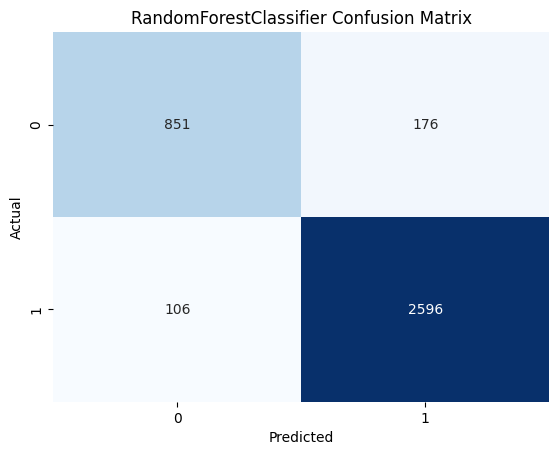

Classifier     RandomForestClassifier
Precision                    0.936508
Recall                        0.96077
F1 Score                     0.948484
Specificity                  0.828627
ROC AUC                      0.968218
Accuracy                     0.924377
Name: 1, dtype: object

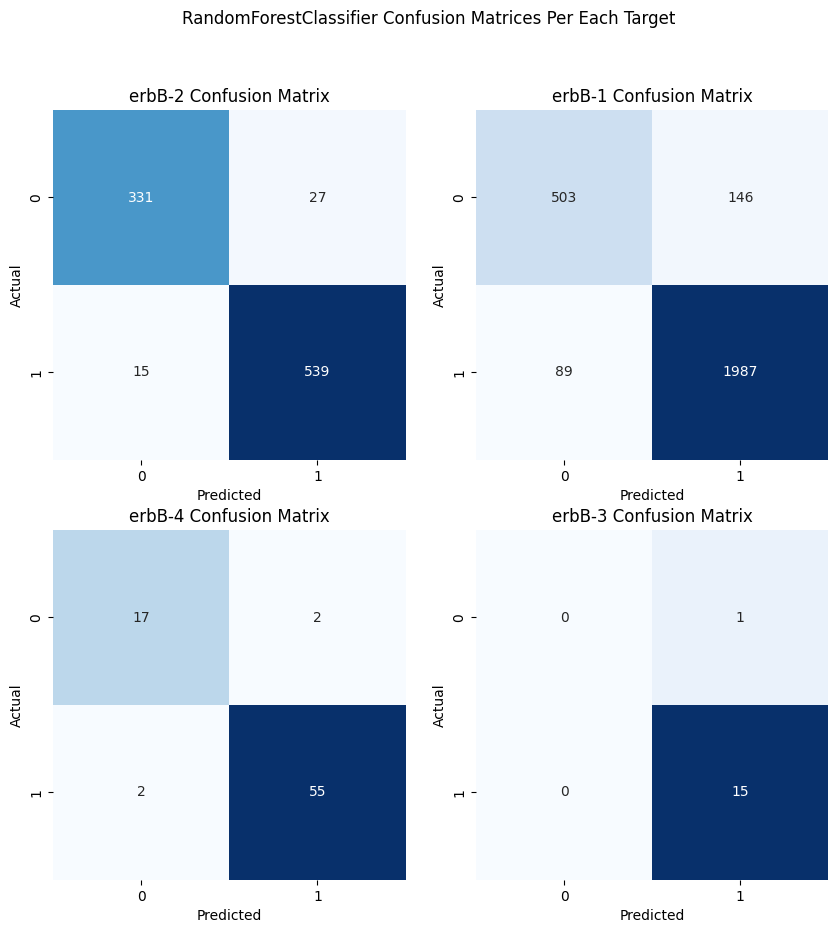

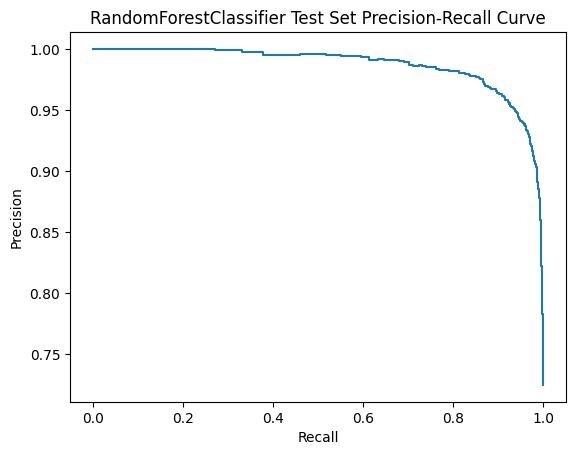

<Figure size 640x480 with 0 Axes>

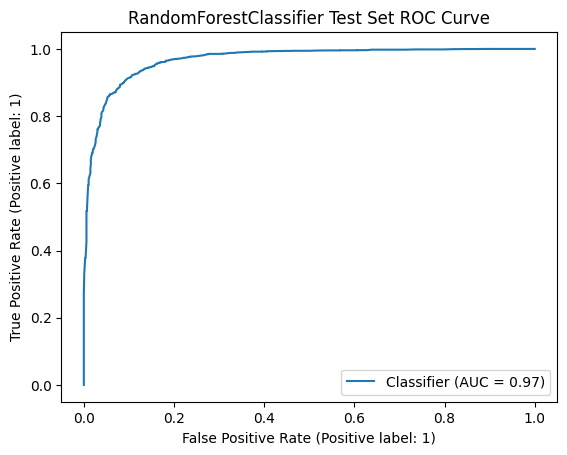

In [ ]:
test_results = train_test_model(p_RF, x_train, y_train, x_test, y_test, 'RandomForestClassifier', test_results)

# K Neighbors Classifier

In [ ]:
classifier_KN = KNeighborsClassifier()

parameters_KN = {
    'n_neighbors': [3, 5, 7, 10],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
}

best_estimator_KN = find_best_params(classifier_KN, parameters_KN, x_train, y_train, cv)
#{'algorithm': 'auto', 'n_neighbors': 5, 'weights': 'distance'}

n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 4146
max_resources_: 12438
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 8
n_resources: 4146
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END .....algorithm=auto, n_neighbors=3, weights=uniform; total time=   0.5s
[CV] END .....algorithm=auto, n_neighbors=3, weights=uniform; total time=   0.8s
[CV] END .....algorithm=auto, n_neighbors=3, weights=uniform; total time=   0.5s
[CV] END .....algorithm=auto, n_neighbors=3, weights=uniform; total time=   0.5s
[CV] END .....algorithm=auto, n_neighbors=3, weights=uniform; total time=   0.5s
[CV] END ....algorithm=auto, n_neighbors=3, weights=distance; total time=   0.4s
[CV] END ....algorithm=auto, n_neighbors=3, weights=distance; total time=   0.4s
[CV] END ....algorithm=auto, n_neighbors=3, weights=distance; total time=   0.7s
[CV] END ....algorithm=auto, n_neighbors=3, weights=distance; total time=   0.4s
[CV] END 

mean_test_score  std_test_score  \
6          0.750403        0.012449   
4          0.767496        0.014627   
2          0.774731        0.012805   
0          0.775276        0.013481   
1          0.797935        0.013132   
5          0.804597        0.010668   
7          0.805577        0.016757   
3          0.806202        0.010237   
9          0.844962        0.005698   
8          0.848663        0.003259   
10         0.860150        0.006229   

                                               params  
6   {'algorithm': 'auto', 'n_neighbors': 10, 'weig...  
4   {'algorithm': 'auto', 'n_neighbors': 7, 'weigh...  
2   {'algorithm': 'auto', 'n_neighbors': 5, 'weigh...  
0   {'algorithm': 'auto', 'n_neighbors': 3, 'weigh...  
1   {'algorithm': 'auto', 'n_neighbors': 3, 'weigh...  
5   {'algorithm': 'auto', 'n_neighbors': 7, 'weigh...  
7   {'algorithm': 'auto', 'n_neighbors': 10, 'weig...  
3   {'algorithm': 'auto', 'n_neighbors': 5, 'weigh...  
9   {'algorithm': 'auto', 'n_neighbors': 10, 'weig...  
8   {'algorithm': 'auto', 'n_neighbors': 7, 'weigh...  
10  {'algorithm': 'auto', 'n_neighbors': 5, 'weigh...

In [ ]:
classifier_KN = KNeighborsClassifier(algorithm =  'auto', n_neighbors = 5, weights = 'distance')
p_KN = pipeline.make_pipeline(column_transformer, classifier_KN)

fit_time  score_time  test_precision  test_recall   test_f1  \
0  0.499778    7.349212        0.971053     0.889871  0.928691   
1  0.468915    8.913018        0.976064     0.885048  0.928331   
2  0.347524    7.797169        0.969217     0.885852  0.925661   
3  0.464339    6.723760        0.974199     0.880225  0.924831   
4  0.333662    7.504827        0.967714     0.892196  0.928422   

   test_specificity  test_roc_auc  test_accuracy  
0          0.973473      0.978040       0.931672  
1          0.978296      0.971709       0.931672  
2          0.971865      0.974006       0.928859  
3          0.976669      0.970554       0.928428  
4          0.970257      0.968854       0.931242

<Figure size 640x480 with 0 Axes>

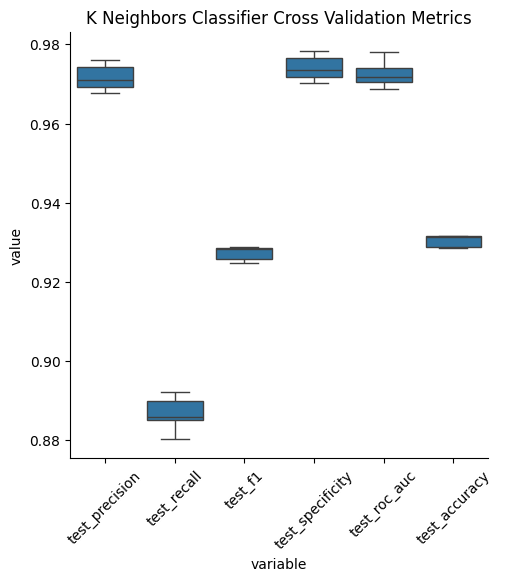

Mean Scores:
fit_time            0.422844
score_time          7.657597
test_precision      0.971649
test_recall         0.886639
test_f1             0.927187
test_specificity    0.974112
test_roc_auc        0.972633
test_accuracy       0.930375
dtype: float64


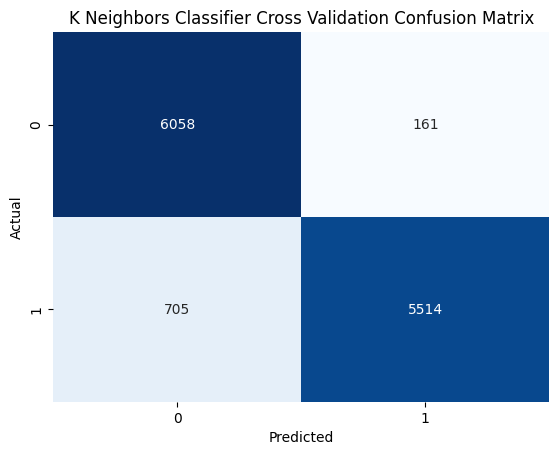

<Figure size 640x480 with 0 Axes>

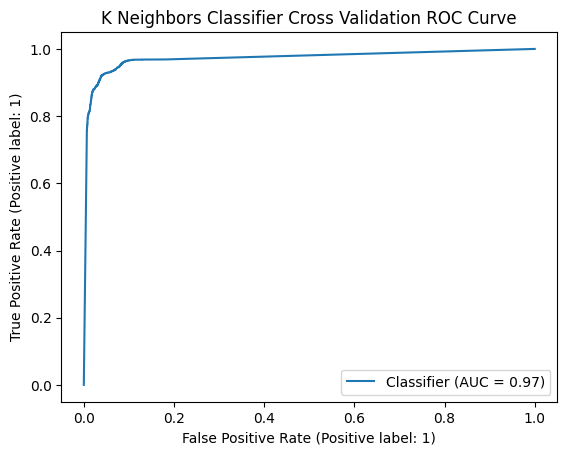

In [ ]:
cross_val_mean_results = cross_validate(p_KN, x_train, y_train, 'K Neighbors Classifier',
                                        cross_val_mean_results, cross_val_results)

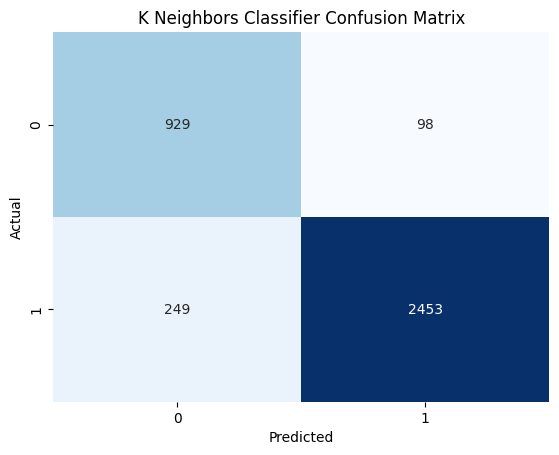

Classifier     K Neighbors Classifier
Precision                    0.961584
Recall                       0.907846
F1 Score                     0.933943
Specificity                  0.904576
ROC AUC                       0.95061
Accuracy                     0.906946
Name: 2, dtype: object

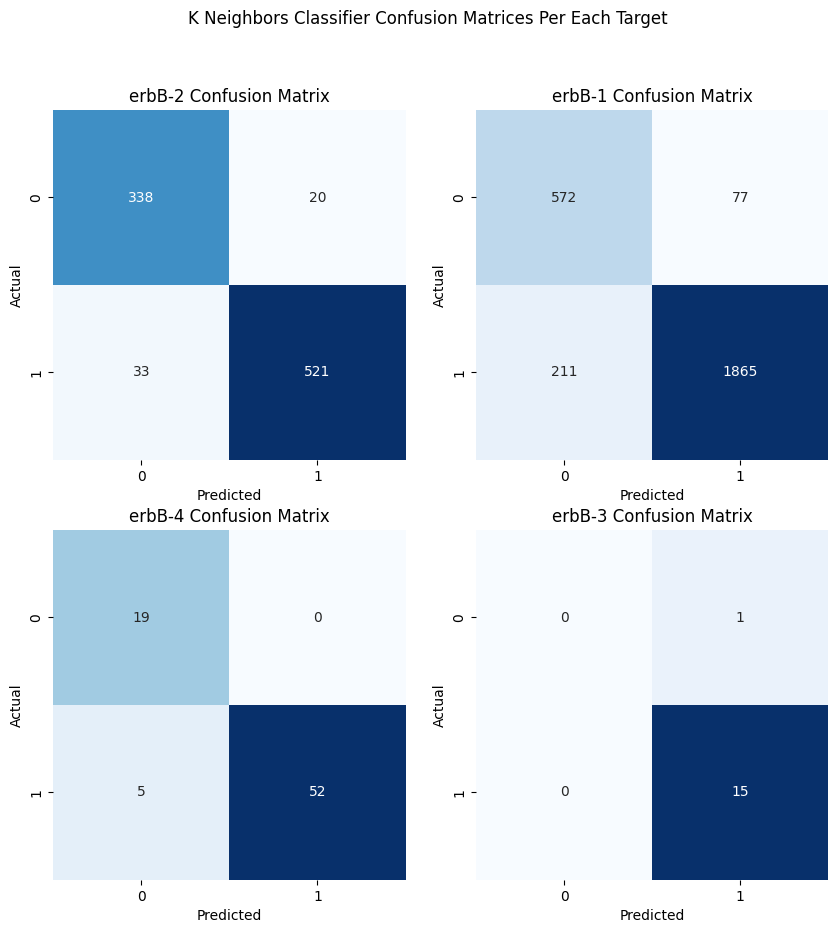

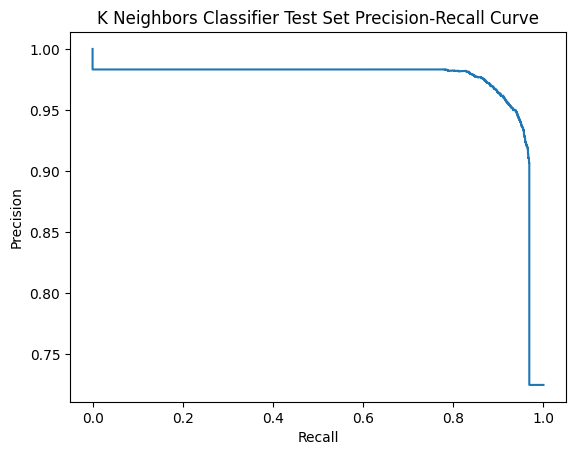

<Figure size 640x480 with 0 Axes>

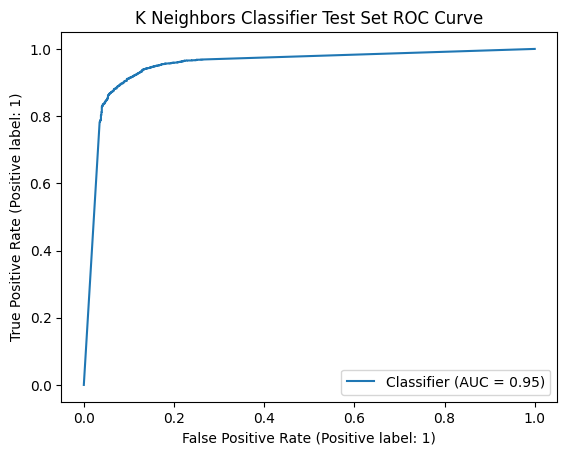

In [ ]:
test_results = train_test_model(p_KN, x_train, y_train, x_test, y_test,
                                'K Neighbors Classifier', test_results)

# Logistic Regression

In [ ]:
classifier_LR = LogisticRegression(random_state = SEED)

parameters_LR = {
    'penalty': ['l1', 'l2', 'elasticnet', None],
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'max_iter' : [10000]
}

best_estimatorLR = find_best_params(classifier_LR, parameters_LR, x_train, y_train, cv)
#C=10, max_iter=10000, penalty=l2

In [ ]:
classifier_LR = LogisticRegression(C=1, penalty='l2', random_state = SEED,
                                  max_iter=1000)
p_LR = pipeline.make_pipeline(column_transformer, classifier_LR)

fit_time  score_time  test_precision  test_recall   test_f1  \
0   9.499039    0.168679        0.931800     0.911576  0.921577   
1   7.856890    0.176872        0.936982     0.908360  0.922449   
2   9.250176    0.176772        0.938127     0.901929  0.919672   
3  10.743333    0.181890        0.939698     0.901929  0.920427   
4   8.666351    0.303492        0.933665     0.905873  0.919559   

   test_specificity  test_roc_auc  test_accuracy  
0          0.933280      0.973598       0.922428  
1          0.938907      0.973635       0.923633  
2          0.940514      0.974724       0.921222  
3          0.942076      0.969486       0.921994  
4          0.935691      0.971483       0.920788

<Figure size 640x480 with 0 Axes>

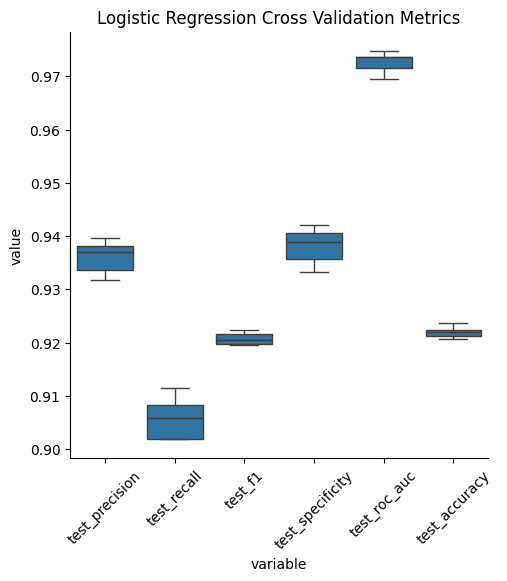

Mean Scores:
fit_time            9.203158
score_time          0.201541
test_precision      0.936054
test_recall         0.905933
test_f1             0.920737
test_specificity    0.938094
test_roc_auc        0.972585
test_accuracy       0.922013
dtype: float64


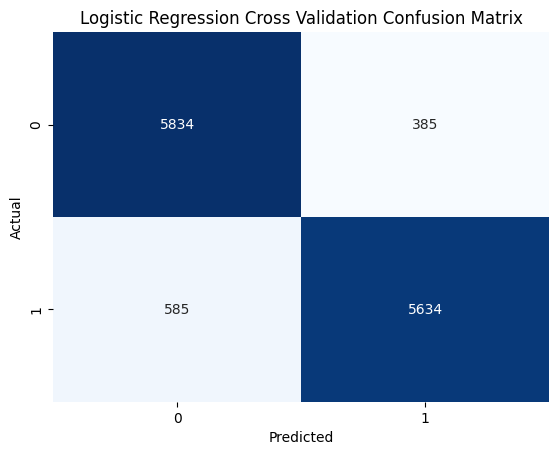

<Figure size 640x480 with 0 Axes>

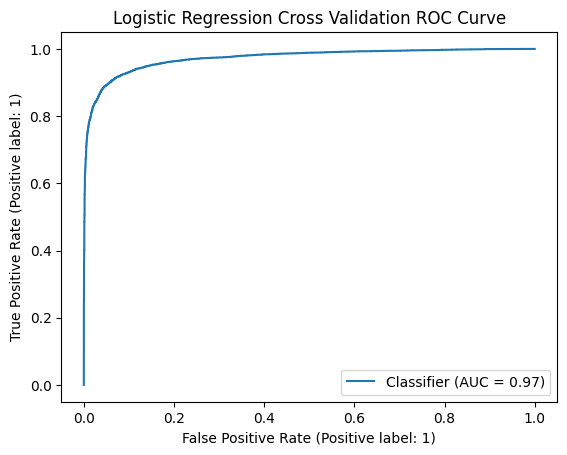

In [ ]:
cross_val_mean_results = cross_validate(p_LR, x_train, y_train, 'Logistic Regression',
                                        cross_val_mean_results, cross_val_results)

In [ ]:
test_results = train_test_model(p_LR, x_train, y_train, x_test, y_test,
                                'Logistic Regression', test_results)

# Gradient Boosting Classifier

In [ ]:
classifier_GB = GradientBoostingClassifier()

parameters_GB = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.1, 0.2, 0.3],
    'max_depth': [2, 3, 5],
    'min_samples_split': [2, 3],
    'min_samples_leaf': [1, 2, 3],
    'max_features': ['None', 'sqrt', 'log2'],
    'subsample': [1.0, 0.8],
}

best_estimator_GB = find_best_params(classifier_GB, parameters_GB, x_train, y_train, cv)
#{'learning_rate': 0.1, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 200, 'subsample': 1.0}

n_iterations: 6
n_required_iterations: 7
n_possible_iterations: 6
min_resources_: 20
max_resources_: 12438
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 972
n_resources: 20
Fitting 5 folds for each of 972 candidates, totalling 4860 fits
[CV] END learning_rate=0.1, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsa

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.4s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.4s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.5s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.5s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=1, mi

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.6s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.5s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.4s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.4s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.5s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.5s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.5s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.5s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=2, mi

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=3, mi

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.5s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.5s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=1, mi

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=1, mi

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.5s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.4s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=2, mi

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=2, mi

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.4s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.4s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.4s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.5s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.5s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=3, mi

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=3, mi

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.5s
[CV] END learning_rate=0.1, max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=3, max_features=None, min_samples_leaf=1, mi

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.7s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.9s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=1, mi

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.5s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.5s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.5s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=2, mi

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=2, mi

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.5s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=1, mi

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.5s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.5s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.4s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=1, mi

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=2, mi

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.4s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.4s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=2, mi

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=3, mi

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.4s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.5s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=3, mi

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=5, max_features=None, min_samples_leaf=1, mi

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.5s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.6s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=2, mi

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=3, mi

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.4s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.4s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.5s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=1, mi

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.4s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.4s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   1.2s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.4s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=1, mi

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.5s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=2, mi

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=2, mi

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.4s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.4s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=3, mi

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=3, mi

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.2, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=2, max_features=None, min_samples_leaf=1, mi

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=1, mi

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.4s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=2, mi

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.5s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.4s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=2, mi

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=3, mi

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.4s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.5s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.4s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=3, mi

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.2, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=1, mi

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.4s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.5s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.5s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.5s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=1, mi

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=1, mi

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=2, mi

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.4s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.4s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.4s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.5s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.5s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=2, mi

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=3, mi

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.5s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.5s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=3, mi

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=3, mi

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=3, max_features=None, min_samples_leaf=1, mi

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   1.2s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.4s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.5s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.5s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.6s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=1, mi

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=2, mi

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.5s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=3, mi

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=3, mi

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.5s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.4s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=1, mi

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=1, mi

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.4s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.4s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.5s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.5s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.4s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.4s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.5s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.5s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=3, mi

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.2, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=5, max_features=None, min_samples_leaf=1, mi

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=1, mi

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=2, mi

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.4s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=2, mi

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.4s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.4s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.4s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.5s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=1, mi

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.5s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.4s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.4s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.5s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.5s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=1, mi

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=2, mi

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.4s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.4s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.5s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.5s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.5s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=3, mi

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=3, mi

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END learning_rate=0.3, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END learning_rate=0.3, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END learning_rate=0.3, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END learning_rate=0.3, max_depth=2, max_features=None, min_samples_leaf=1, mi

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.4s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.4s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=2, mi

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.4s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.4s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.4s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.5s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.5s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=3, mi

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.5s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.5s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=2, mi

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.5s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=3, mi

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.4s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.4s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.4s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.4s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.5s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.5s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=3, mi

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END learning_rate=0.3, max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END learning_rate=0.3, max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END learning_rate=0.3, max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END learning_rate=0.3, max_depth=3, max_features=None, min_samples_leaf=1, mi

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.4s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.5s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.5s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.5s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.5s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=2, mi

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.5s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.5s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=3, mi

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=3, mi

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.4s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=1, mi

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.4s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.4s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.5s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.5s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.7s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.6s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.4s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.7s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.6s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=1, mi

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.4s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.4s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.4s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=2, mi

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=2, mi

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.4s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.4s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.4s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.5s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.5s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.3, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END learning_rate=0.3, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END learning_rate=0.3, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END learning_rate=0.3, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END learning_rate=0.3, max_depth=5, max_features=None, min_samples_leaf=1, mi

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.5s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=2, mi

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.4s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=3, mi

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=1, mi

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.4s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.4s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.5s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.5s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.6s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.5s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=1, mi

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=1, mi

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=1, mi

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=2, mi

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.4s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.5s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.5s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.5s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.5s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=3, mi

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=3, mi

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.4s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.4s
----------
iter: 1
n_candidates: 324
n_resources: 60
Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
1620 fits failed out of a total of 4860.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1620 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py", line 420, in fit
    self._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/uti

[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.4s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=1, mi

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.74260073 0.7693007  0.75475524]
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the train scores are non-finite: [nan nan nan ...  1.  1.  1.]
  warnings.warn(


----------
iter: 2
n_candidates: 108
n_resources: 180
Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.5s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.5s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.5s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.6s
[CV] END learning_rate=0.3, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=1.0; total time=   0.5s
[CV] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500,

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.8342976  0.84278602 0.79657812]
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the train scores are non-finite: [       nan        nan        nan ... 1.         1.         0.95922644]
  warnings.warn(


[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.9s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.8s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.8s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.8s
[CV] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   0.9s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.6s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=1, mi

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.84836053 0.83679987 0.83649176]
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the train scores are non-finite: [       nan        nan        nan ... 0.98912085 1.         1.        ]
  warnings.warn(


----------
iter: 4
n_candidates: 12
n_resources: 1620
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   3.6s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   2.6s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   2.7s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   2.6s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=0.8; total time=   3.3s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500, s

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.90305289 0.90219081 0.90254776]
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the train scores are non-finite: [       nan        nan        nan ... 0.98100025 0.99690546 0.99875751]
  warnings.warn(


[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   3.3s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   3.3s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   4.0s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   3.4s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=500, subsample=0.8; total time=   3.3s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   1.4s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=2, mi

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.91338781 0.91512122 0.91936472]
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the train scores are non-finite: [       nan        nan        nan ... 0.95470883 0.9793179  0.98476524]
  warnings.warn(


{'learning_rate': 0.1, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 200, 'subsample': 1.0}


mean_test_score  std_test_score  \
955         0.400000        0.326599   
948         0.404762        0.349278   
721         0.404762        0.349278   
855         0.426667        0.351757   
847         0.438095        0.364402   
..               ...             ...   
895              NaN             NaN   
896              NaN             NaN   
897              NaN             NaN   
898              NaN             NaN   
899              NaN             NaN   

                                                params  
955  {'learning_rate': 0.3, 'max_depth': 5, 'max_fe...  
948  {'learning_rate': 0.3, 'max_depth': 5, 'max_fe...  
721  {'learning_rate': 0.3, 'max_depth': 2, 'max_fe...  
855  {'learning_rate': 0.3, 'max_depth': 3, 'max_fe...  
847  {'learning_rate': 0.3, 'max_depth': 3, 'max_fe...  
..                                                 ...  
895  {'learning_rate': 0.3, 'max_depth': 5, 'max_fe...  
896  {'learning_rate': 0.3, 'max_depth': 5, 'max_fe...  
897  {'learning_rate': 0.3, 'max_depth': 5, 'max_fe...  
898  {'learning_rate': 0.3, 'max_depth': 5, 'max_fe...  
899  {'learning_rate': 0.3, 'max_depth': 5, 'max_fe...  

[1456 rows x 3 columns]

In [ ]:
classifier_GB = GradientBoostingClassifier(learning_rate = 0.1, max_depth = 5,
                                          max_features = 'sqrt', min_samples_leaf = 1,
                                          min_samples_split = 3, n_estimators = 200,
                                          subsample = 1.0, random_state = SEED)

p_GB = pipeline.make_pipeline(column_transformer, classifier_GB)

fit_time  score_time  test_precision  test_recall   test_f1  \
0  8.232326    0.193912        0.915569     0.950161  0.932544   
1  7.386975    0.260029        0.916925     0.949357  0.932859   
2  7.837497    0.189796        0.923930     0.937299  0.930567   
3  7.903863    0.216137        0.920635     0.932476  0.926518   
4  7.258977    0.176542        0.920886     0.936444  0.928600   

   test_specificity  test_roc_auc  test_accuracy  
0          0.912379      0.981742       0.931270  
1          0.913987      0.981766       0.931672  
2          0.922830      0.983306       0.930064  
3          0.919549      0.978724       0.926015  
4          0.919614      0.980933       0.928026

<Figure size 640x480 with 0 Axes>

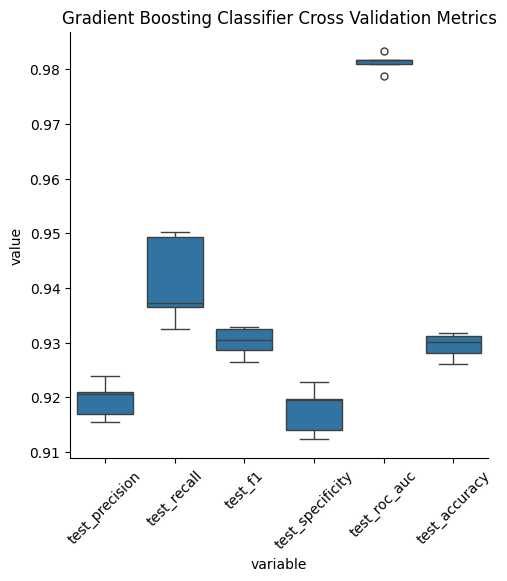

Mean Scores:
fit_time            7.723928
score_time          0.207283
test_precision      0.919589
test_recall         0.941147
test_f1             0.930218
test_specificity    0.917672
test_roc_auc        0.981294
test_accuracy       0.929409
dtype: float64


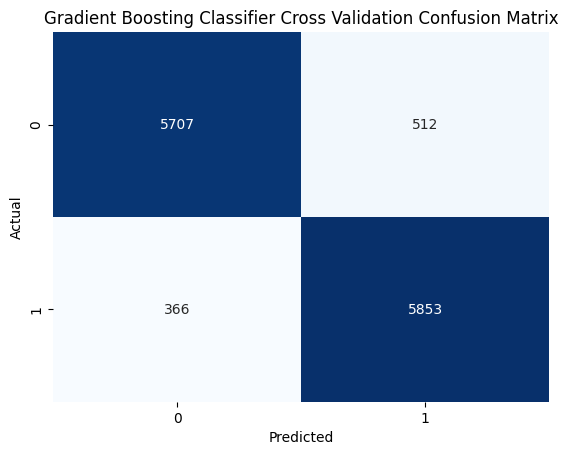

<Figure size 640x480 with 0 Axes>

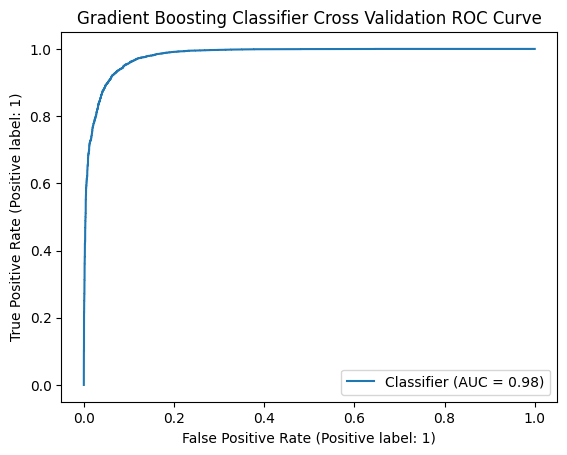

In [ ]:
cross_val_mean_results = cross_validate(p_GB, x_train, y_train,'Gradient Boosting Classifier',
                                        cross_val_mean_results, cross_val_results)

In [ ]:
test_results = train_test_model(p_GB, x_train, y_train, x_test, y_test,
                                'Gradient Boosting Classifier', test_results)

# Visualisations

In [ ]:
cross_val_results_df = pd.concat(cross_val_results, ignore_index=True)
display(cross_val_results_df)

In [ ]:
display(test_results)

Classifier Precision    Recall  F1 Score Specificity  \
0                           SVC  0.941558  0.912287  0.926692    0.851022   
1        RandomForestClassifier  0.936508   0.96077  0.948484    0.828627   
2        K Neighbors Classifier  0.961584  0.907846  0.933943    0.904576   
3           Logistic Regression  0.934636  0.920799  0.927666    0.830574   
4  Gradient Boosting Classifier  0.925926  0.943745  0.934751    0.801363   

    ROC AUC  Accuracy  
0  0.945668  0.895414  
1  0.968218  0.924377  
2   0.95061  0.906946  
3   0.94947  0.895951  
4  0.955159  0.904532

In [ ]:
cross_val_results_df.to_csv("crossvalresults.csv", sep=',', index=False, encoding='utf-8')
test_results.to_csv("testresults.csv", sep=',', index=False, encoding='utf-8')

In [ ]:
test_results  = pd.read_csv("testresults.csv", sep=',', header=0)
cross_val_results_df  = pd.read_csv("crossvalresults.csv", sep=',', header=0)

Classifier  Precision    Recall  F1 Score  Specificity  \
0                           SVC   0.941558  0.912287  0.926692     0.851022   
1        RandomForestClassifier   0.936508  0.960770  0.948484     0.828627   
2        K Neighbors Classifier   0.961584  0.907846  0.933943     0.904576   
3           Logistic Regression   0.934636  0.920799  0.927666     0.830574   
4  Gradient Boosting Classifier   0.925926  0.943745  0.934751     0.801363   

    ROC AUC  Accuracy  
0  0.945668  0.895414  
1  0.968218  0.924377  
2  0.950610  0.906946  
3  0.949470  0.895951  
4  0.955159  0.904532

In [ ]:
std_dev = cross_val_results_df.groupby('Classifier').agg('std')
display(std_dev)

fit_time  score_time  test_precision  \
Classifier                                                            
Gradient Boosting Classifier   0.397951    0.032750        0.003349   
K Neighbors Classifier         0.076468    0.804060        0.003455   
Logistic Regression            1.068000    0.057189        0.003250   
Random Forest Classifier       0.537492    0.028462        0.002472   
SVC                           11.489814    6.004762        0.007572   

                              test_recall   test_f1  test_specificity  \
Classifier                                                              
Gradient Boosting Classifier     0.008074  0.002684          0.004344   
K Neighbors Classifier           0.004627  0.001801          0.003330   
Logistic Regression              0.004177  0.001250          0.003582   
Random Forest Classifier         0.004754  0.002835          0.002641   
SVC                              0.006365  0.004174          0.008062   

                              test_roc_auc  test_accuracy  
Classifier                                                 
Gradient Boosting Classifier      0.001674       0.002369  
K Neighbors Classifier            0.003556       0.001598  
Logistic Regression               0.002093       0.001110  
Random Forest Classifier          0.001440       0.002776  
SVC                               0.002992       0.004205

<ipython-input-75-faf103e8aebb>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=10)
<ipython-input-75-faf103e8aebb>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=10)
<ipython-input-75-faf103e8aebb>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=10)
<ipython-input-75-faf103e8aebb>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=10)
<ipython-input-75-faf103e8aebb>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=10)
<ipython-input-75-faf103e8aebb>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=10

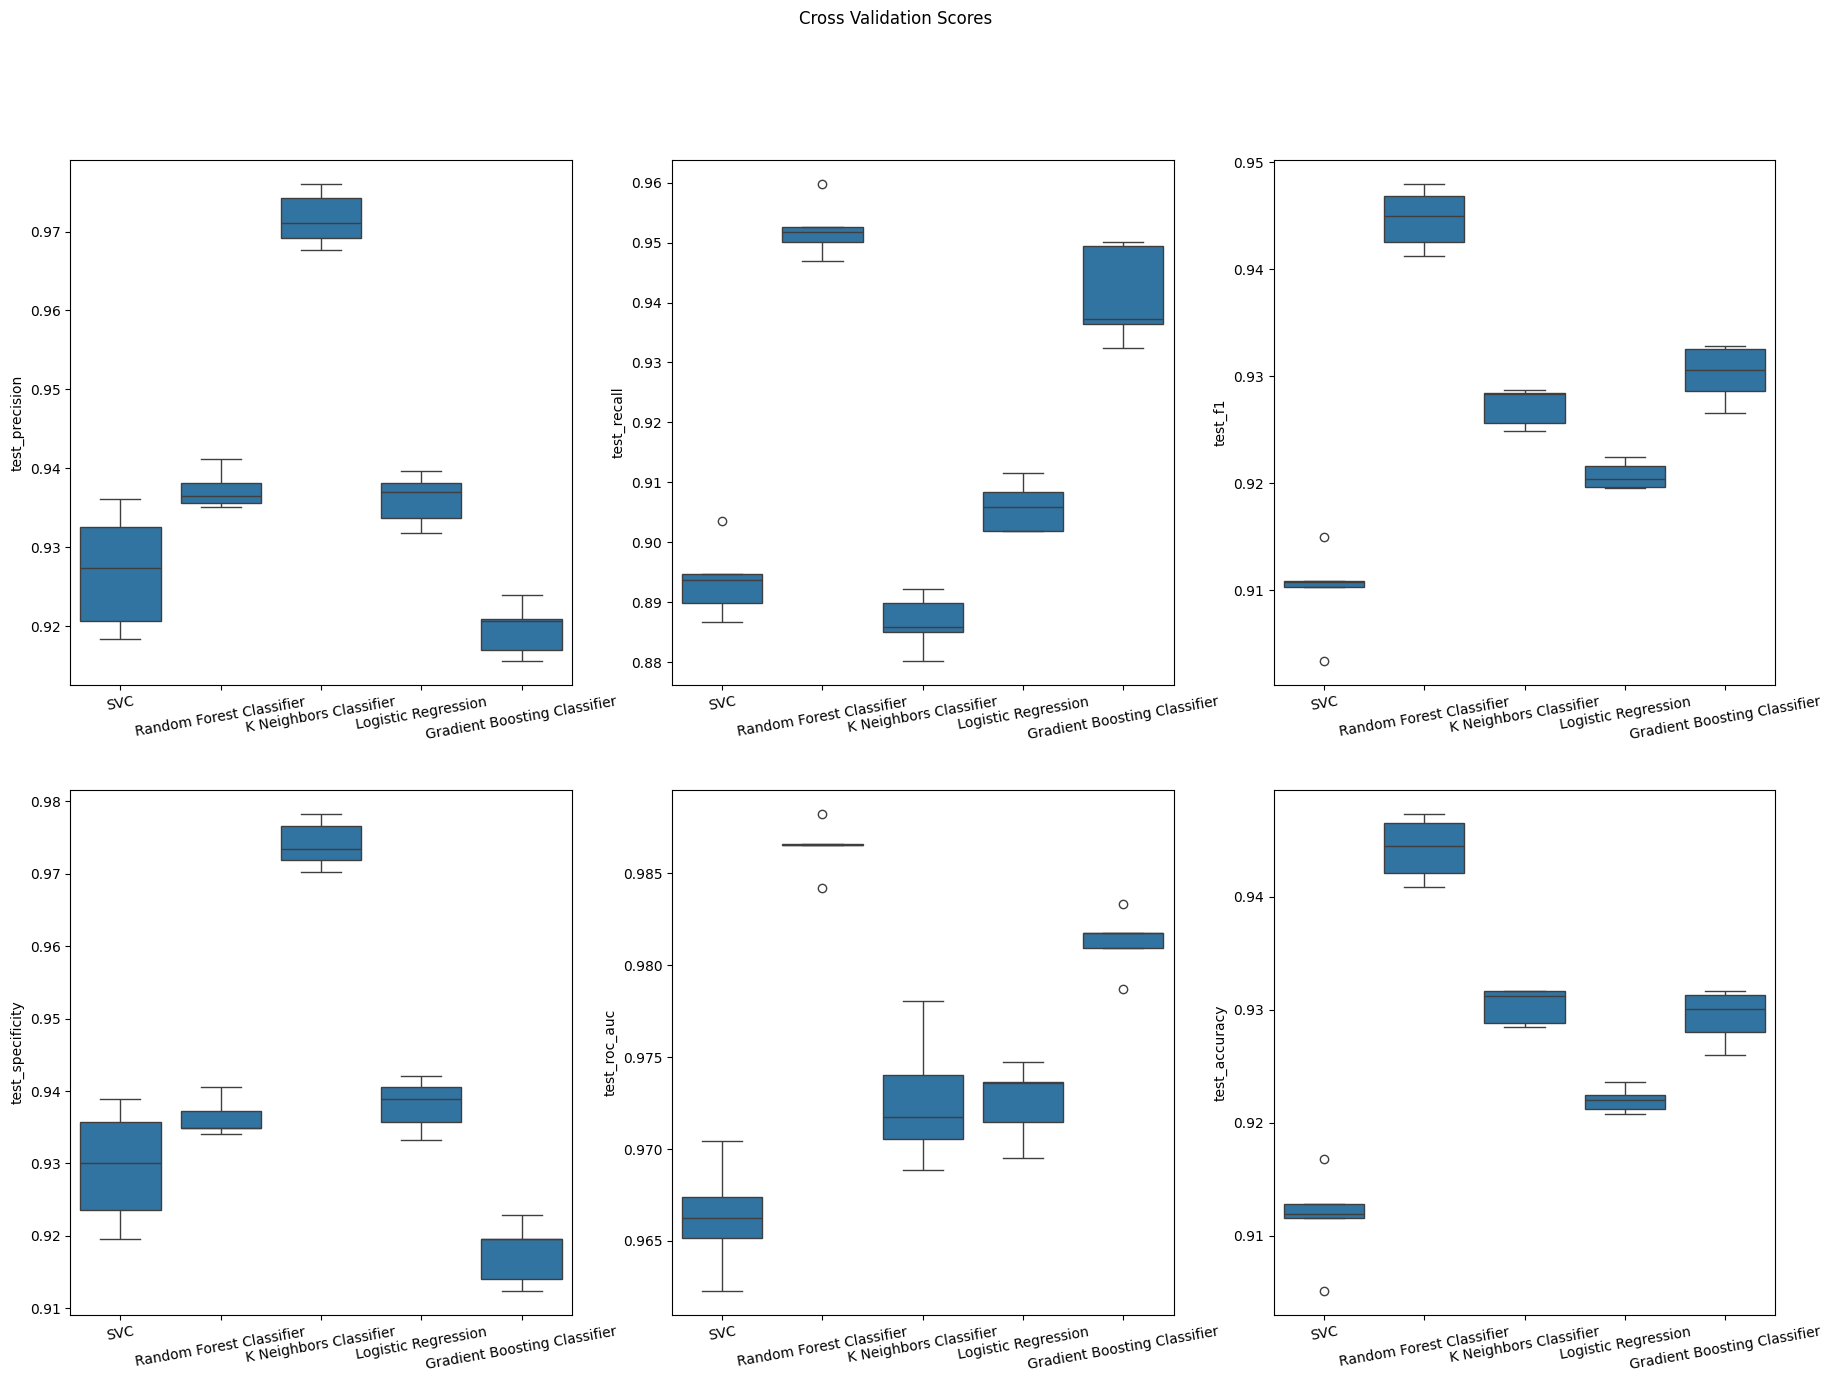

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(22, 15))
axes = axes.flatten()

for i, metric in enumerate(cross_val_results_df.columns[slice(2, -1)]):

    ax = axes[i]
    melted_data = cross_val_results_df.melt(id_vars=['Classifier'],
                                              var_name='Metric', value_name='Score')
    filtered_data = melted_data[melted_data['Metric'] == metric]

    sns.boxplot(ax = ax , data=filtered_data, x='Classifier', y='Score')
    ax.set_xlabel('')
    ax.set_ylabel(metric)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=10)

plt.suptitle('Cross Validation Scores')
plt.show()

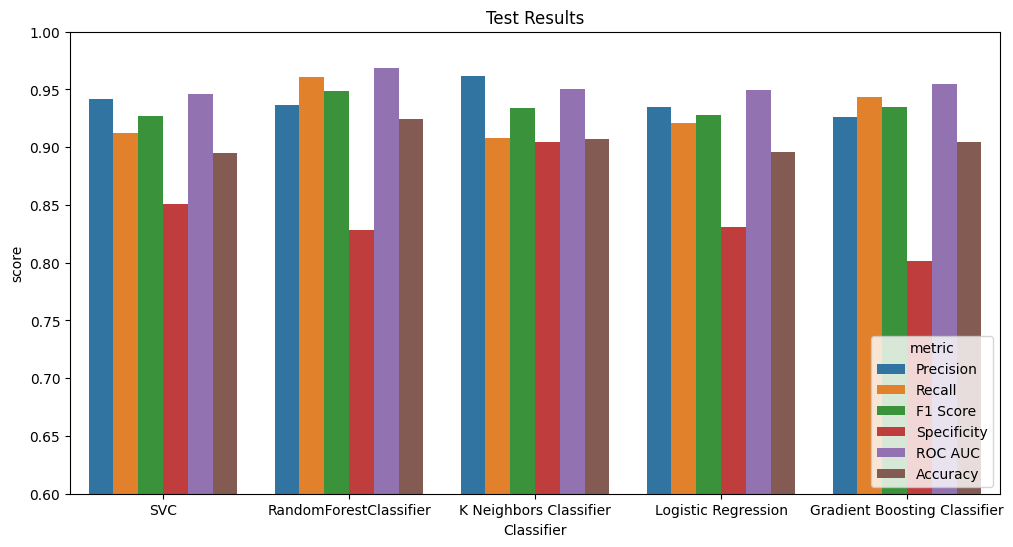

In [ ]:
plt.figure(figsize=(12, 6))

ax = sns.barplot(data = test_results.melt(
      id_vars = 'Classifier', value_name = 'score',var_name = 'metric'),
            x = 'Classifier', y = 'score', hue = 'metric')

sns.move_legend(ax, "lower right")
plt.ylim(0.6, 1.0)
plt.title('Test Results')
plt.show()

In [ ]:
display(cross_val_mean_results)
cross_val_mean_results.to_csv("crossvalmeanresults.csv", sep=',', index=False, encoding='utf-8')

Classifier Precision    Recall  F1 Score Specificity  \
0                           SVC  0.927013  0.893713  0.910031     0.92957   
1      Random Forest Classifier  0.937325  0.952242   0.94472    0.936324   
2        K Neighbors Classifier  0.971649  0.886639  0.927187    0.974112   
3           Logistic Regression  0.936054  0.905933  0.920737    0.938094   
4  Gradient Boosting Classifier  0.919589  0.941147  0.930218    0.917672   

    ROC AUC  Accuracy  
0  0.966294  0.911641  
1  0.986426  0.944283  
2  0.972633  0.930375  
3  0.972585  0.922013  
4  0.981294  0.929409

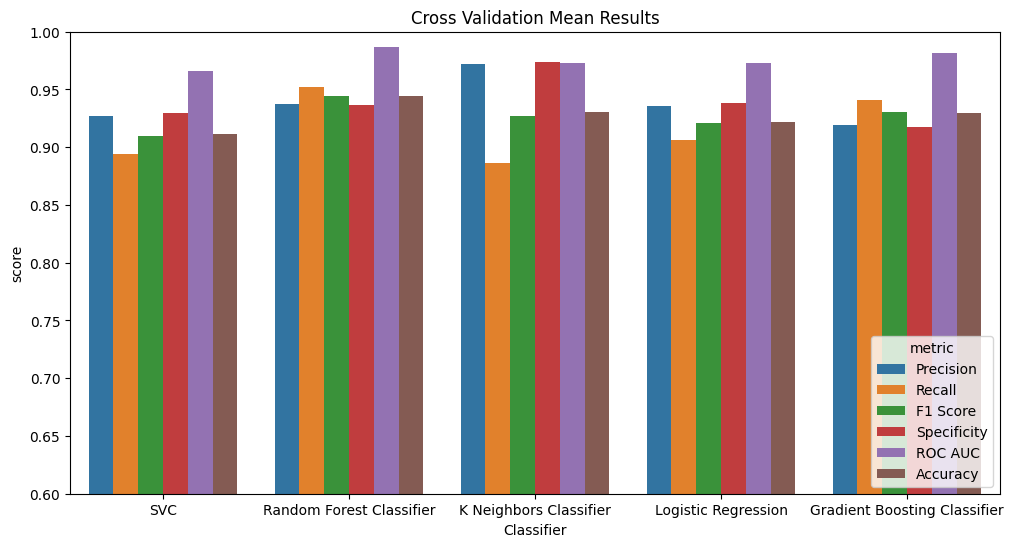

In [ ]:
plt.figure(figsize=(12, 6))

ax = sns.barplot(data = cross_val_mean_results.melt(
      id_vars = 'Classifier', value_name = 'score',var_name = 'metric'),
            x = 'Classifier', y = 'score', hue = 'metric')

sns.move_legend(ax, "lower right")
plt.ylim(0.6, 1.0)
plt.title('Cross Validation Mean Results')
plt.show()

In [ ]:
def plot_confusion_matrix(actual, predicted, classifier_name):

  matrix = confusion_matrix(actual, predicted)

  plt.figure()
  fig = sns.heatmap(matrix, annot=True, fmt='d', cmap="Blues", cbar=False)
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.title(f'{classifier_name} Confusion Matrix')
  plt.show()


def calculate_metrics(actual, predicted, proba):

  accuracy = accuracy_score(actual, predicted)
  print('Accuracy: %f' % accuracy)

  precision = precision_score(actual, predicted)
  print('Precision: %f' % precision)

  recall = recall_score(actual, predicted)
  print('Recall: %f' % recall)

  f1 = f1_score(actual, predicted)
  print('F1 score: %f' % f1)

  specificity = specificity_score(actual, predicted)
  print('Specificity score: %f' % specificity)

  roc_auc = roc_auc_score(actual, proba)
  print('ROC AUC score: %f' % roc_auc)

  return precision, recall , f1, specificity, roc_auc, accuracy


def plot_roc_curve(actual, predictions, classifier_name):
  plt.figure()
  RocCurveDisplay.from_predictions(actual, predictions)
  plt.title(f'{classifier_name} ROC Curve')
  plt.show()


def plot_learning_curve_loss(history, classifier_name):

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'{classifier_name} Training and Validation Loss')
    plt.legend()
    plt.show()

def plot_learning_curve_acc(history, classifier_name):

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(1, len(accuracy) + 1)
    plt.plot(epochs, accuracy, 'b', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'{classifier_name} Training and Validation Accuracy')
    plt.legend()
    plt.show()



def plot_precision_recall_curve(actual, predictions, classifier_name):

    precision, recall, _ = precision_recall_curve(actual, predictions)
    PrecisionRecallDisplay(precision=precision, recall=recall).plot()
    plt.title(f'{classifier_name} Precision-Recall Curve')
    plt.show()

# Graph Neural Network (Single Protein)

In [ ]:
dataSingleProtein = dataOutliersRemoved[dataOutliersRemoved['Target ChEMBL ID'] == 'CHEMBL203']

atomic_symbols = ['C', 'N', 'O', 'S', 'F', 'Si', 'P', 'Cl', 'Br', 'Mg', 'Na','Ca',
                  'Fe', 'As', 'Al', 'I', 'B', 'V', 'K', 'Tl', 'Yb','Sb', 'Sn',
                  'Ag', 'Pd', 'Co', 'Se', 'Ti', 'Zn', 'H','Li', 'Ge', 'Cu', 'Au',
                  'Ni', 'Cd', 'In', 'Mn', 'Zr','Cr', 'Pt', 'Hg' , 'Pb', 'Unknown']

symbols_dic = {symbol: i for i, symbol in enumerate(atomic_symbols)}

In [ ]:
def get_atom_features(mol):

    features = []
    for atom in mol.GetAtoms():

      atom_symbol = symbols_dic.get(atom.GetSymbol())

      feature_vector = [
                          atom_symbol,
                          atom.GetDegree(),
                          atom.GetTotalNumHs(),
                          atom.GetImplicitValence(),
                          atom.GetIsAromatic(),
                          atom.GetAtomicNum(),
                          atom.GetHybridization(),
                          atom.GetFormalCharge(),
                          atom.GetChiralTag(),
                          atom.GetNumExplicitHs()
      ]
      features.append(feature_vector)

    return np.array(features)

def mol_to_adjacency_matrix(mol):

    num_atoms = mol.GetNumAtoms()
    adjacency_mx = np.zeros((num_atoms, num_atoms), dtype=np.int64)

    for bond in mol.GetBonds():
        bond_type = bond.GetBondTypeAsDouble()
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        adjacency_mx[i, j] = bond_type
        adjacency_mx[j, i] = bond_type

    return adjacency_mx

def mol_to_graph(index, mol):

    x = get_atom_features(mol) #node feature vector
    a  = mol_to_adjacency_matrix(mol) #adjacency matrix
    a = gcn_filter(a, symmetric=True)
    y = dataSingleProtein.iloc[index, 4]#labels

    spektralGraph = Graph(x=x, a=a, y=y)
    return spektralGraph

In [ ]:
class MyDataset(Dataset):
    def __init__(self, transforms=None, **kwargs):
        super().__init__(transforms=transforms, **kwargs)

    def read(self):
        graphs = []
        for i, mol in enumerate(dataSingleProtein['Molecule']):
            graph = mol_to_graph(i, mol)
            graphs.append(graph)
        return graphs

    def get_labels(self):
      labels = []
      for graph in self.graphs:
        labels.append(graph.y)
      return labels


graphData = MyDataset()
graphData

MyDataset(n_graphs=9016)

In [ ]:
batch_size = 32
epochs = 10

def create_loaders(train, validate, test):

    loader_tr = BatchLoader(train, batch_size=batch_size, mask=True, shuffle=False)
    loader_va = BatchLoader(validate, batch_size=batch_size, mask=True, shuffle=False)
    loader_te = BatchLoader(test, batch_size=batch_size, mask=True, shuffle=False)

    return loader_tr, loader_va, loader_te


def split_data(dataset):

    np.random.seed(SEED)
    idxs = np.random.permutation(len(dataset))
    split_va, split_te = int(0.7 * len(dataset)), int(0.85 * len(dataset))
    idx_tr, idx_va, idx_te = np.split(idxs, [split_va, split_te])
    dataset_tr = dataset[idx_tr]
    dataset_va = dataset[idx_va]
    dataset_te = dataset[idx_te]

    return dataset_tr, dataset_va, dataset_te


In [ ]:
dataset_tr, dataset_va, dataset_te = split_data(graphData)
loader_tr, loader_va, loader_te = create_loaders(dataset_tr, dataset_va,
                                                 dataset_te)

In [ ]:
train_labels = []

for graph in dataset_tr:
  train_labels.append(graph.y)

true_labels = []

for i, batch in enumerate(loader_te):
    if i == loader_te.steps_per_epoch:
        break
    labels = batch[1]
    true_labels.extend(labels)

loader_tr, loader_va, loader_te = create_loaders(dataset_tr, dataset_va,
                                                 dataset_te) #reset loaders

In [ ]:
from spektral.layers import GlobalSumPool, GraphMasking, GATConv, GeneralConv, GINConvBatch, GlobalMaxPool, GlobalAvgPool


class GCN(Model):

    def __init__(self, n_hidden, n_labels):
        super().__init__()

        self.graph_conv1 = GCNConv(n_hidden, activation='relu',
                                   kernel_initializer=keras.initializers.glorot_uniform(seed=SEED))
        self.graph_conv2 = GCNConv(n_hidden, activation='relu',
                                   kernel_initializer=keras.initializers.glorot_uniform(seed=SEED))
        self.graph_conv3 = GCNConv(n_hidden, activation='relu',
                                   kernel_initializer=keras.initializers.glorot_uniform(seed=SEED))

        self.pool = GlobalMaxPool()
        self.dropout = Dropout(0.5, seed=SEED)
        self.dense = Dense(n_labels, 'sigmoid',
                           kernel_initializer=keras.initializers.glorot_uniform(seed=SEED))

    def call(self, inputs):
        x, a = inputs
        x = self.graph_conv1([x, a])
        x = self.graph_conv2([x, a])
        x = self.graph_conv3([x, a])

        out = self.dropout(x)
        out = self.pool(out)
        out = self.dense(out)

        return out


In [ ]:
modelGCN = GCN(32, graphData.n_labels)

optimizer = keras.optimizers.Adam(learning_rate=0.001)
modelGCN.compile(optimizer = optimizer, loss = 'binary_crossentropy',
                 metrics=['accuracy'], run_eagerly=True)

callback = keras.callbacks.EarlyStopping(monitor='val_loss')

In [ ]:
from sklearn.utils import class_weight


class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes = np.unique(train_labels),
                                                  y = train_labels)

class_weight_dict = {
    0 : class_weights[0],
    1 : class_weights[1]
}

historyGCN = modelGCN.fit(loader_tr.load(), steps_per_epoch=loader_tr.steps_per_epoch,
                    epochs=epochs, validation_data=loader_va.load(),
                    validation_steps=loader_va.steps_per_epoch, class_weight = class_weight_dict,
                        shuffle=False, callbacks=[callback])


print("Testing model")
lossGCN, accGCN = modelGCN.evaluate(loader_te.load(), steps=loader_te.steps_per_epoch)
print("Done. Test loss: {}. Test acc: {}".format(lossGCN, accGCN))

loader_tr, loader_va, loader_te = create_loaders(dataset_tr, dataset_va, dataset_te) #reset loaders

print("Predicting on test data")
predictionsGCN = modelGCN.predict(loader_te.load(), steps = loader_te.steps_per_epoch)

predicted_classesGCN = np.where(predictionsGCN>= 0.5, 1, 0)

Epoch 1/10
198/198 [==============================] - 16s 81ms/step - loss: 0.6760 - accuracy: 0.5864 - val_loss: 0.6525 - val_accuracy: 0.6154
Epoch 2/10
198/198 [==============================] - 16s 82ms/step - loss: 0.6373 - accuracy: 0.6493 - val_loss: 0.6201 - val_accuracy: 0.7751
Epoch 3/10
198/198 [==============================] - 16s 81ms/step - loss: 0.5967 - accuracy: 0.7013 - val_loss: 0.5707 - val_accuracy: 0.8003
Epoch 4/10
198/198 [==============================] - 17s 84ms/step - loss: 0.5711 - accuracy: 0.7279 - val_loss: 0.5415 - val_accuracy: 0.8114
Epoch 5/10
198/198 [==============================] - 16s 82ms/step - loss: 0.5540 - accuracy: 0.7386 - val_loss: 0.5259 - val_accuracy: 0.8070
Epoch 6/10
198/198 [==============================] - 16s 80ms/step - loss: 0.5474 - accuracy: 0.7430 - val_loss: 0.5261 - val_accuracy: 0.8025
Testing model
43/43 [==============================] - 1s 33ms/step - loss: 0.5412 - accuracy: 0.7775
Done. Test loss: 0.541154146194458

In [ ]:
modelGCN.summary()

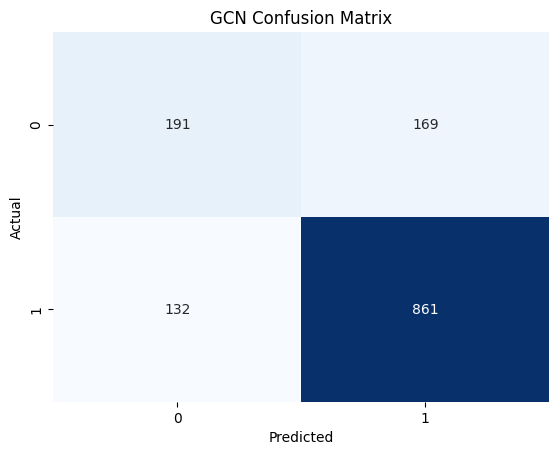

Accuracy: 0.777531
Precision: 0.835922
Recall: 0.867069
F1 score: 0.851211
Specificity score: 0.530556
ROC AUC score: 0.799687


<Figure size 640x480 with 0 Axes>

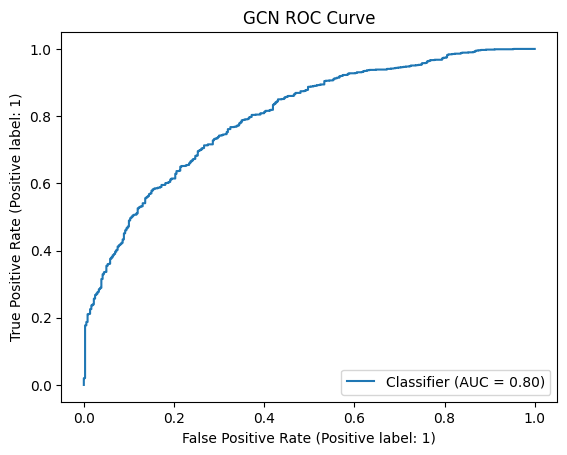

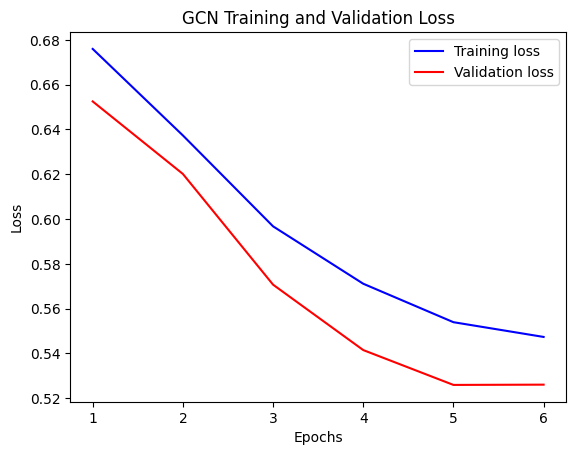

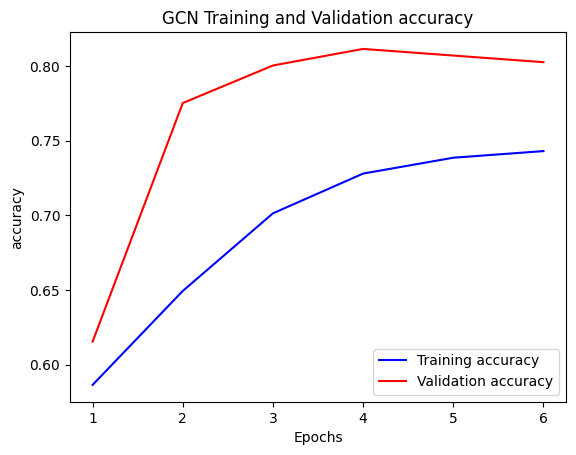

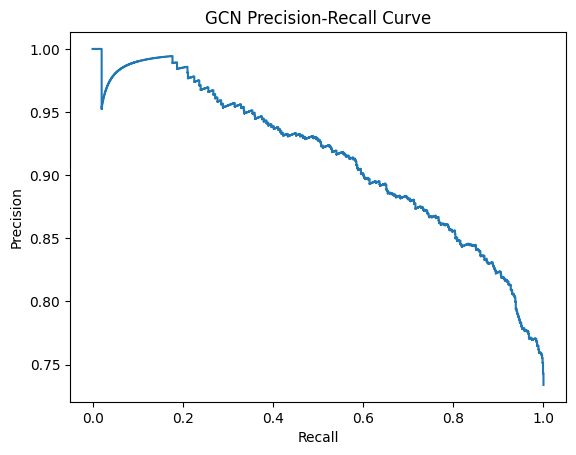

In [ ]:
plot_confusion_matrix(true_labels, predicted_classesGCN, 'GCN')

precision, recall , f1, specificity, roc_auc, accuracy = calculate_metrics(
    true_labels, predicted_classesGCN, predictionsGCN)

plot_roc_curve(true_labels, predictionsGCN, 'GCN')
plot_learning_curve_loss(historyGCN, 'GCN')
plot_learning_curve_acc(historyGCN, 'GCN')
plot_precision_recall_curve(true_labels, predictionsGCN, 'GCN')

In [ ]:
test_results.loc[len(test_results), :] = {'Classifier' : 'GCN',
                                    'Precision' : precision,
                                    'Recall': recall,
                                    'F1 Score' : f1,
                                    'Specificity' : specificity,
                                    'ROC AUC' : roc_auc,
                                    'Accuracy': accuracy}

display(test_results)

# MLP

In [ ]:
class MLP(Model):

  def __init__(self, n_hidden, n_labels):
        super().__init__()

        self.dense1 = Dense(64, activation='relu')
        self.dense2 = Dense(32, activation='relu')
        self.dense3 = Dense(n_labels, 'sigmoid')

        self.dropout =  Dropout(0.5)

  def call(self, inputs):

        out = self.dense1(inputs)
        out = self.dropout(out)
        out = self.dense2(out)
        out = self.dropout(out)
        out = self.dense3(out)

        return out

In [ ]:
modelMLP = MLP(64, 1)

optimizer = keras.optimizers.Adam(learning_rate=0.001)
modelMLP.compile(optimizer=optimizer, loss = 'binary_crossentropy', metrics=['accuracy'], run_eagerly=True)
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

In [ ]:
epochs = 10

historyMLP = modelMLP.fit(x = x_train, y = y_train, validation_split = 0.2,
                          batch_size=32, epochs=epochs, callbacks=[callback])

In [ ]:
print("Testing model")
lossMLP, accMLP = modelMLP.evaluate(x=np.asarray(x_test).astype('float32'), y=y_test)
print("Done. Test loss: {}. Test acc: {}".format(lossMLP, accMLP))

print("Predicting on test data")
predictionsMLP = modelMLP.predict(x=np.asarray(x_test).astype('float32'))

predicted_classesMLP = np.where(predictionsMLP >= 0.5, 1, 0)

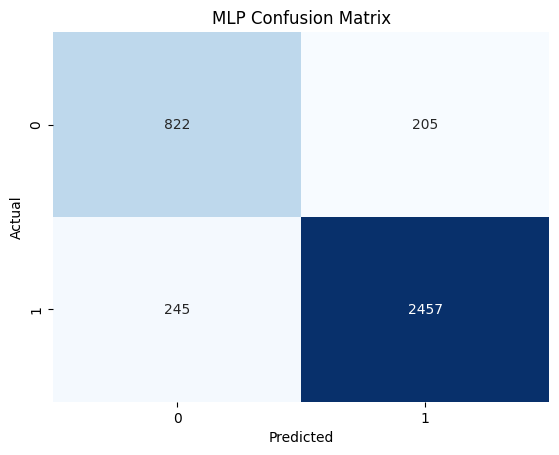

Accuracy: 0.879324
Precision: 0.922990
Recall: 0.909326
F1 score: 0.916107
Specificity score: 0.800389
ROC AUC score: 0.943880


<Figure size 640x480 with 0 Axes>

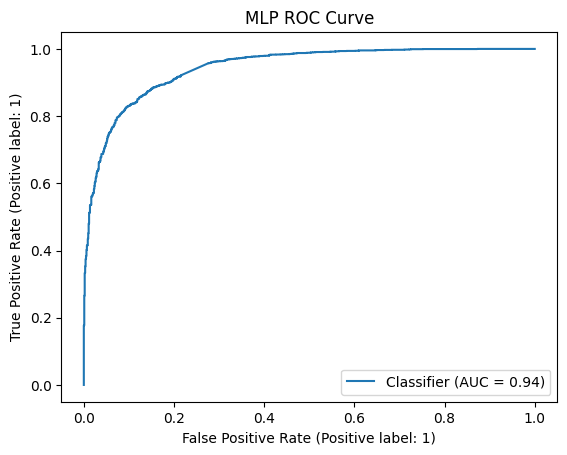

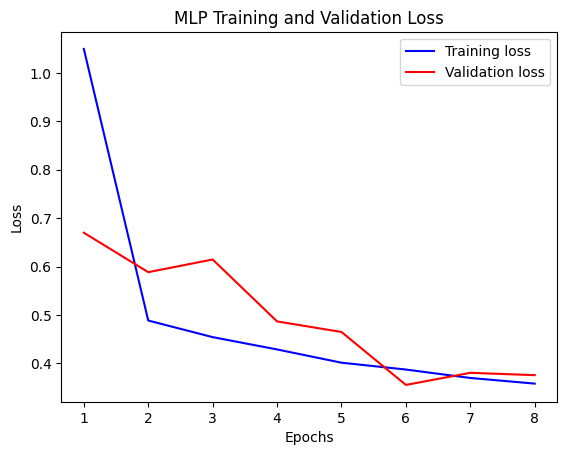

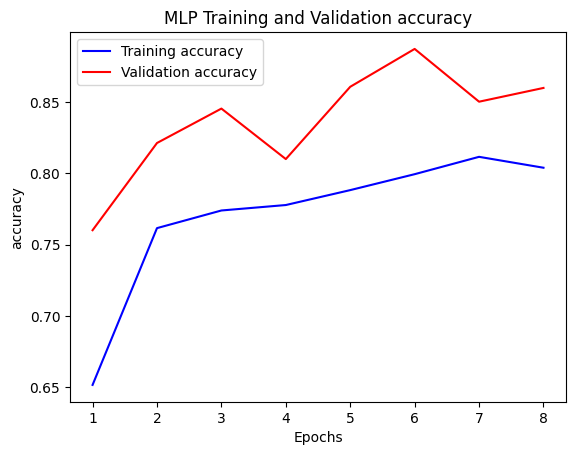

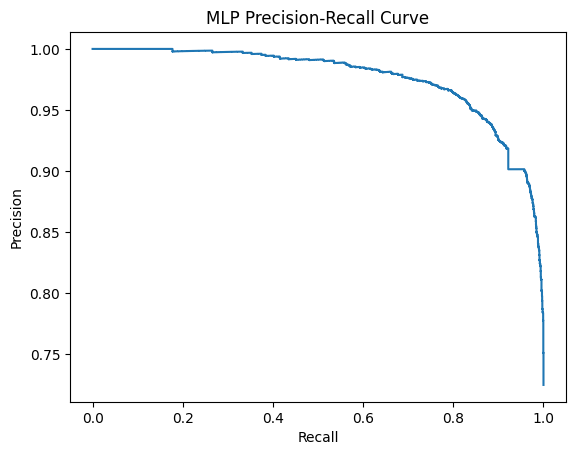

In [ ]:
plot_confusion_matrix(y_test, predicted_classesMLP, 'MLP')

precision, recall , f1, specificity, roc_auc, accuracy = calculate_metrics(
    y_test, predicted_classesMLP, predictionsMLP)

plot_roc_curve(y_test, predictionsMLP, 'MLP')
plot_learning_curve_loss(historyMLP, 'MLP')
plot_learning_curve_acc(historyMLP, 'MLP')
plot_precision_recall_curve(y_test, predictionsMLP, 'MLP')

In [ ]:
test_results.loc[len(test_results), :] = {'Classifier' : 'MLP',
                                    'Precision' : precision,
                                    'Recall': recall,
                                    'F1 Score' : f1,
                                    'Specificity' : specificity,
                                    'ROC AUC' : roc_auc,
                                    'Accuracy': accuracy}

display(test_results)

In [ ]:
test_results.to_csv("testresultsNN.csv", sep=',', index=False, encoding='utf-8')

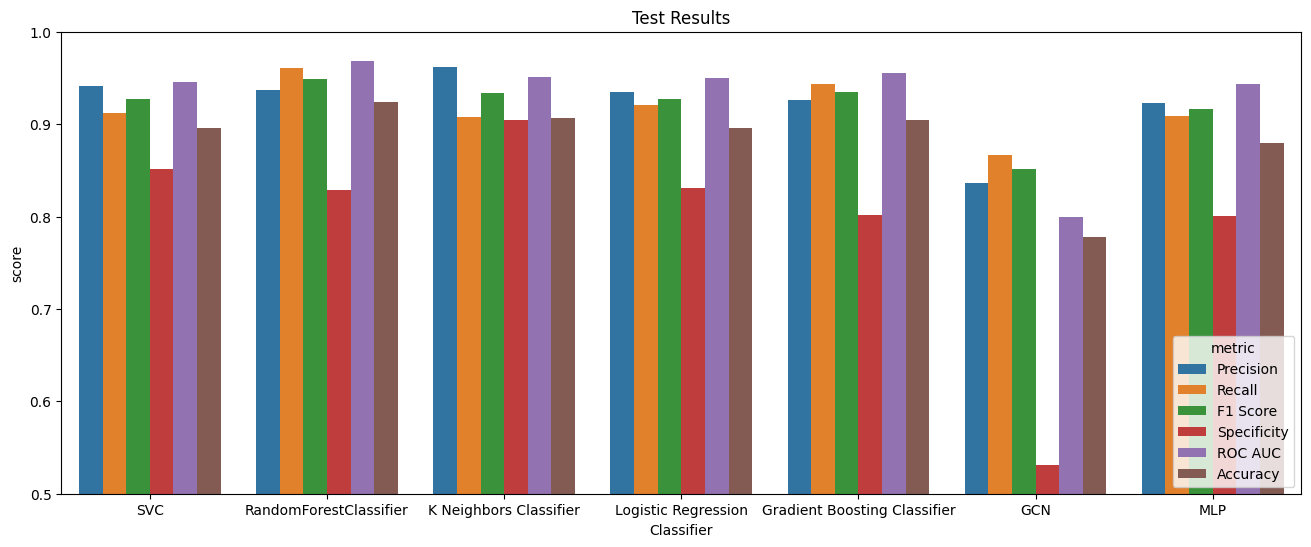

In [ ]:
plt.figure(figsize=(16, 6))

ax = sns.barplot(data = test_results.melt(
      id_vars = 'Classifier', value_name = 'score',var_name = 'metric'),
            x = 'Classifier', y = 'score', hue = 'metric')

sns.move_legend(ax, "lower right")
plt.ylim(0.5, 1.0)
plt.title('Test Results')
plt.show()